In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import DataConversionWarning
from sklearn.model_selection import GridSearchCV
import warnings

In [2]:
warnings.filterwarnings("ignore", category=DataConversionWarning)

from ucimlrepo import fetch_ucirepo 
  
# fetch datasets (http://archive.ics.uci.edu/dataset/357/occupancy+detection)(http://archive.ics.uci.edu/dataset/1/abalone)(http://archive.ics.uci.edu/dataset/186/wine+quality)
occupancy_detection = fetch_ucirepo(id=357)
abalone = fetch_ucirepo(id=1)
wine_quality = fetch_ucirepo(id=186) 

# data (as pandas dataframes) 
X_occ = occupancy_detection.data.features 
y_occ = occupancy_detection.data.targets 
X_abal = abalone.data.features
y_abal = abalone.data.targets
X_wine = wine_quality.data.features 
y_wine = wine_quality.data.targets 

In [3]:
#occupancy data cleaning
X_occ = X_occ[X_occ['date'] !='Temperature']
y_occ.dropna(inplace=True)
X_occ.drop('date', axis=1, inplace=True)

C:\Users\alecw\AppData\Local\Temp\ipykernel_11916\2348210357.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_occ.dropna(inplace=True)
C:\Users\alecw\AppData\Local\Temp\ipykernel_11916\2348210357.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_occ.drop('date', axis=1, inplace=True)


In [4]:
#wine data cleaning

#changes values to 1 when quality >= 7 and 0 when quality < 7
y_wine["quality"] = np.where(y_wine["quality"] >= 7, 1, 0)
y_wine

C:\Users\alecw\AppData\Local\Temp\ipykernel_11916\404999478.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_wine["quality"] = np.where(y_wine["quality"] >= 7, 1, 0)


,quality
0,0
1,0
2,0
3,0
4,0
...,...
6492,0
6493,0
6494,0
6495,1


In [5]:
#abalone dataset cleaning 

#one hot encoding for sex variable 
X_abal = pd.get_dummies(X_abal, columns=["Sex"], prefix="Sex")
one_hot_columns = [col for col in X_abal.columns if col.startswith("Sex_")]
X_abal[one_hot_columns] = X_abal[one_hot_columns].astype(float)

#changes target to 1 where age < 10 and 0 if age > 10
y_abal["Age"] = np.where(y_abal['Rings'] < 8.5, 1, 0)
y_abal = y_abal.drop('Rings', axis=1)

C:\Users\alecw\AppData\Local\Temp\ipykernel_11916\1224252225.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_abal["Age"] = np.where(y_abal['Rings'] < 8.5, 1, 0)


In [6]:
knn_param_grid = {
    'n_neighbors': [2, 5, 7, 10],
    'metric': ['euclidean', 'manhattan'] 
}

# Random Forest hyperparameters
rf_param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [5, 10, 15],
    'max_features': ['sqrt', 'log2']
}

# SVM hyperparameters
svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'], 
    'gamma': ['scale', 'auto']
}

# Function to test a model with GridSearchCV and plot the accuracy results
def plot_model_hyperparameters(model, param_grid, X_train, y_train, model_name, scoring='accuracy'):
    # Use GridSearchCV with cross-validation
    grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1, scoring=scoring)
    grid_search.fit(X_train, y_train)
    
    # Extract results and sort by accuracy
    results = grid_search.cv_results_
    mean_test_scores = results['mean_test_score']
    param_values = [str(params) for params in results['params']]
    
    # Sort the results by mean test score in descending order
    sorted_indices = np.argsort(mean_test_scores)[::-1]
    mean_test_scores_sorted = np.array(mean_test_scores)[sorted_indices]
    param_values_sorted = np.array(param_values)[sorted_indices]
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.barh(param_values_sorted[:10], mean_test_scores_sorted[:10], color='lightblue')  # Top 10 params
    plt.xlabel('Accuracy')
    plt.ylabel('Hyperparameters')
    plt.title(f'{model_name} Hyperparameter Tuning')
    plt.show()
    plot_heatmap_for_params(grid_search, model_name)
    # Print the best hyperparameters
    best_params = grid_search.best_params_
    best = grid_search.best_estimator_
    print(f"Best hyperparameters for {model_name}: {best_params}")
    return best_params

In [7]:
def plot_heatmap_for_params(grid_search, model_name):
    """
    This function plots a heatmap based on the results of a GridSearchCV for the first two parameters.
    
    - grid_search: The fitted GridSearchCV object.
    - model_name: Name of the model for plotting purposes.
    """
    results = grid_search.cv_results_
    
    # Get the names of the hyperparameters (only the first two)
    param_names = list(results['params'][0].keys())
    
    # Ensure there are at least two parameters to plot
    if len(param_names) < 2:
        print(f"Not enough parameters to create a heatmap for {model_name}.")
        return
    
    # Only consider the first two parameters
    param_1_name = param_names[0]
    param_2_name = param_names[1]
    
    # Get the unique values for each of the first two hyperparameters
    param_1_values = np.unique(results[f'param_{param_1_name}'])
    param_2_values = np.unique(results[f'param_{param_2_name}'])
    
    # Create a 2D matrix to store mean test scores (accuracy)
    scores_matrix = np.zeros((len(param_1_values), len(param_2_values)))
    
    # Fill the matrix with mean test scores
    for i, param_1 in enumerate(param_1_values):
        for j, param_2 in enumerate(param_2_values):
            # Get the index of the current combination
            mask = (results[f'param_{param_1_name}'] == param_1) & (results[f'param_{param_2_name}'] == param_2)
            scores_matrix[i, j] = np.mean(results['mean_test_score'][mask])
    
    # Plotting the heatmap for the first two parameters
    plt.figure(figsize=(10, 8))
    sns.heatmap(scores_matrix, annot=True, xticklabels=param_2_values, yticklabels=param_1_values,
                cmap="YlGnBu", fmt=".3f")
    plt.title(f'{model_name} Hyperparameter Heatmap ({param_1_name} vs {param_2_name})')
    plt.xlabel(param_2_name)
    plt.ylabel(param_1_name)
    plt.show()

In [8]:
def rf_fit(X, Y, size):
    accuracy = np.array([0.0,0.0,0.0])
    X_train, X_test, y_train, y_test = train_test_split(X, Y.values.ravel(), test_size=size, random_state=42)
    best_param = plot_model_hyperparameters(RandomForestClassifier(), rf_param_grid, X_train, y_train, 'Random Forest')
    for i in range(3):
        clf = RandomForestClassifier(**best_param)
        clf.fit(X_train,y_train)
        test_pred = clf.predict(X_test)
        test_acc = accuracy_score(y_test, test_pred)
        train_pred = clf.predict(X_train)
        train_acc = accuracy_score(y_train, train_pred)
        val = cross_val_score(RandomForestClassifier(**best_param), X_train, y_train, cv=5)
        accuracy[0] += train_acc
        accuracy[1] += val.mean()
        accuracy[2] += test_acc
    
    return clf, accuracy/3.0

def knn_fit(X,Y,size):
    accuracy = np.array([0.0,0.0,0.0])
    #split train and test data
    X_train, X_test, y_train, y_test = train_test_split(X, Y.values.ravel(), test_size=size, random_state=42)
    
    #normalize data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    best_param = plot_model_hyperparameters(KNeighborsClassifier(), knn_param_grid, X_train, y_train, 'KNN')
    for i in range(3):
        #fit and calcualte accuracy scores of model
        clf = KNeighborsClassifier(**best_param)
        clf.fit(X_train, y_train)
        test_pred = clf.predict(X_test)
        test_acc = accuracy_score(y_test, test_pred)
        train_pred = clf.predict(X_train)
        train_acc = accuracy_score(y_train, train_pred)
        val = cross_val_score(KNeighborsClassifier(**best_param), X_train, y_train, cv=5)
        accuracy[0] += train_acc
        accuracy[1] += val.mean()
        accuracy[2] += test_acc
    
    return clf, accuracy/3.0
    
def svm_fit(X,Y,size):
    accuracy = np.array([0.0,0.0,0.0])
    X_train, X_test, y_train, y_test = train_test_split(X, Y.values.ravel(), test_size=size, random_state=42)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    best_param = plot_model_hyperparameters(svm.SVC(), svm_param_grid, X_train, y_train, 'SVM')
    for i in range(3):
        clf = svm.SVC(**best_param)
        clf.fit(X_train,y_train)
        
        test_pred = clf.predict(X_test)
        test_acc = accuracy_score(y_test, test_pred)
        
        train_pred = clf.predict(X_train)
        train_acc = accuracy_score(y_train, train_pred)
        
        val = cross_val_score(svm.SVC(**best_param), X_train, y_train, cv=5)
        
        accuracy[0] += train_acc
        accuracy[1] += val.mean()
        accuracy[2] += test_acc
    
    return clf, accuracy/3.0
    

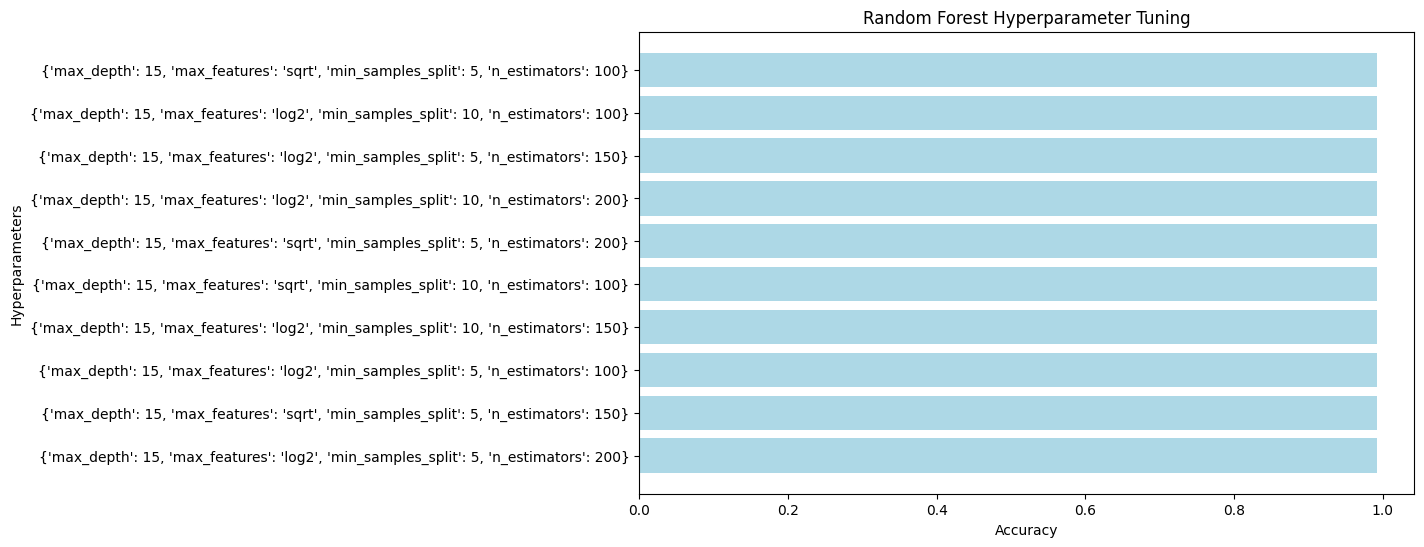

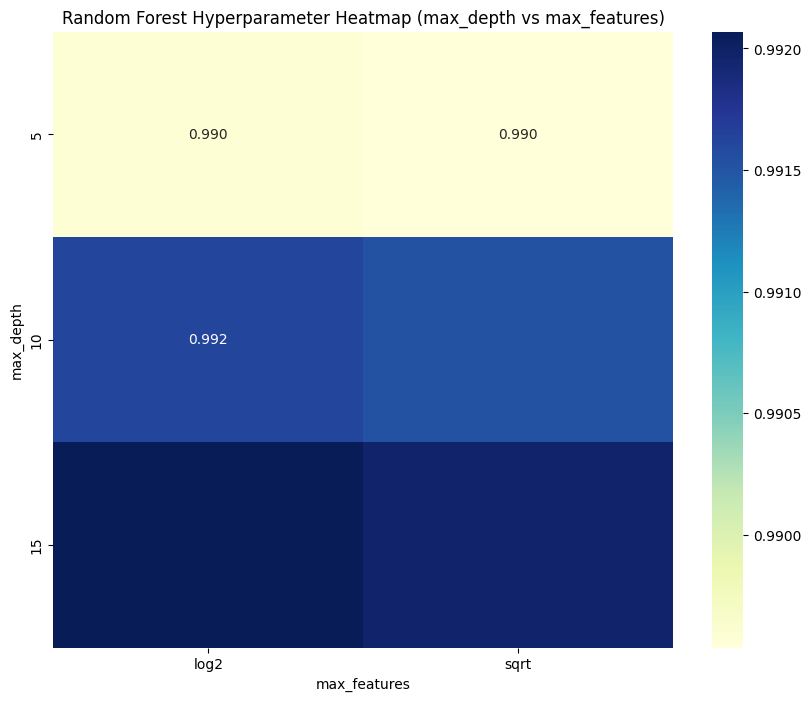

Best hyperparameters for Random Forest: {'max_depth': 15, 'max_features': 'log2', 'min_samples_split': 5, 'n_estimators': 200}


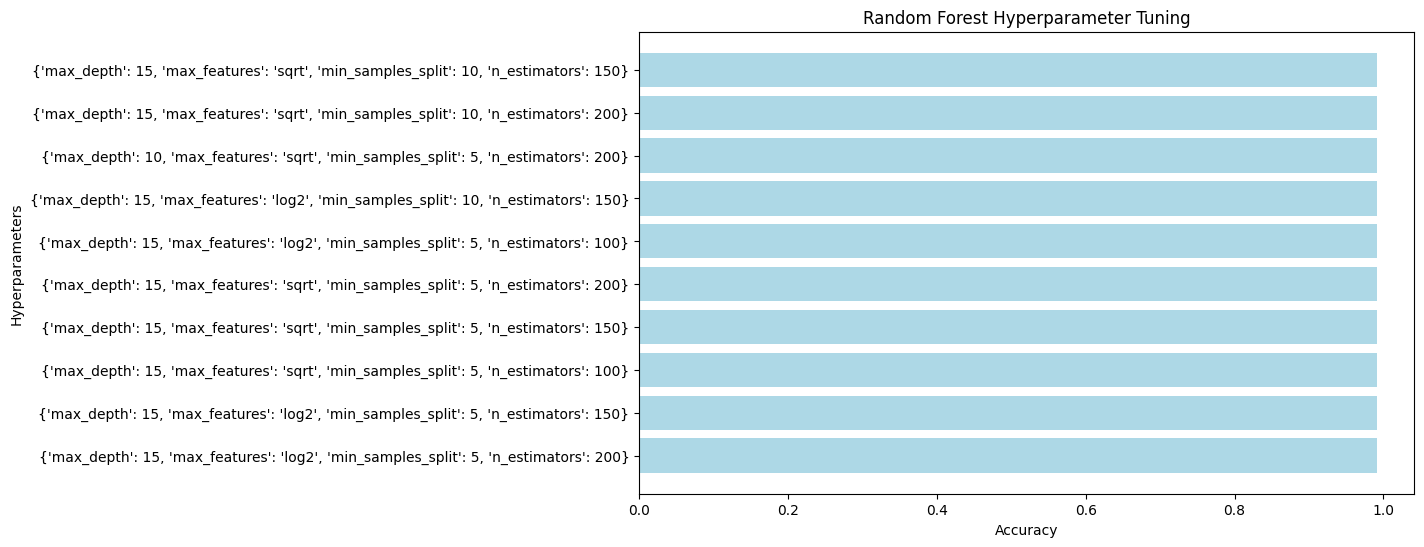

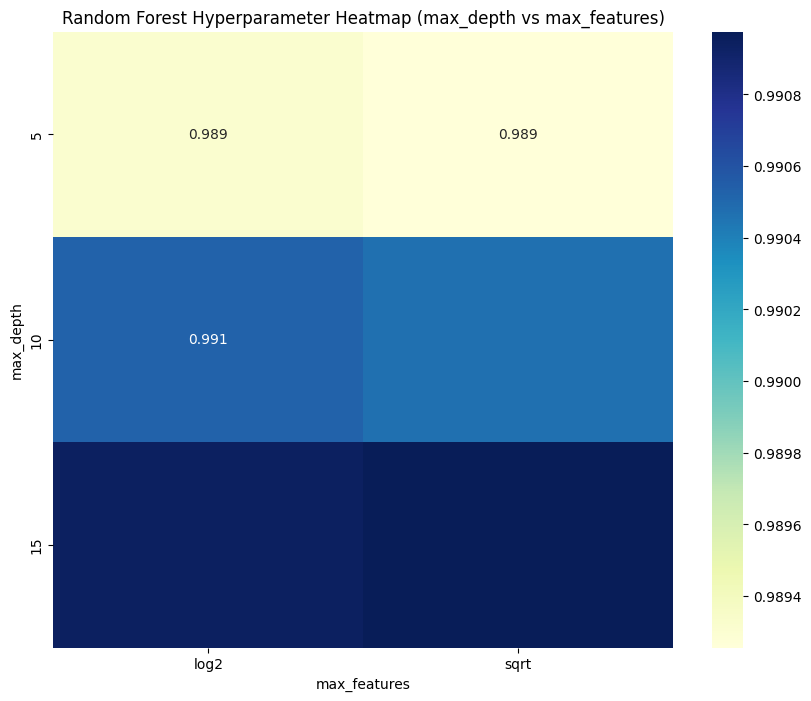

Best hyperparameters for Random Forest: {'max_depth': 15, 'max_features': 'log2', 'min_samples_split': 5, 'n_estimators': 200}


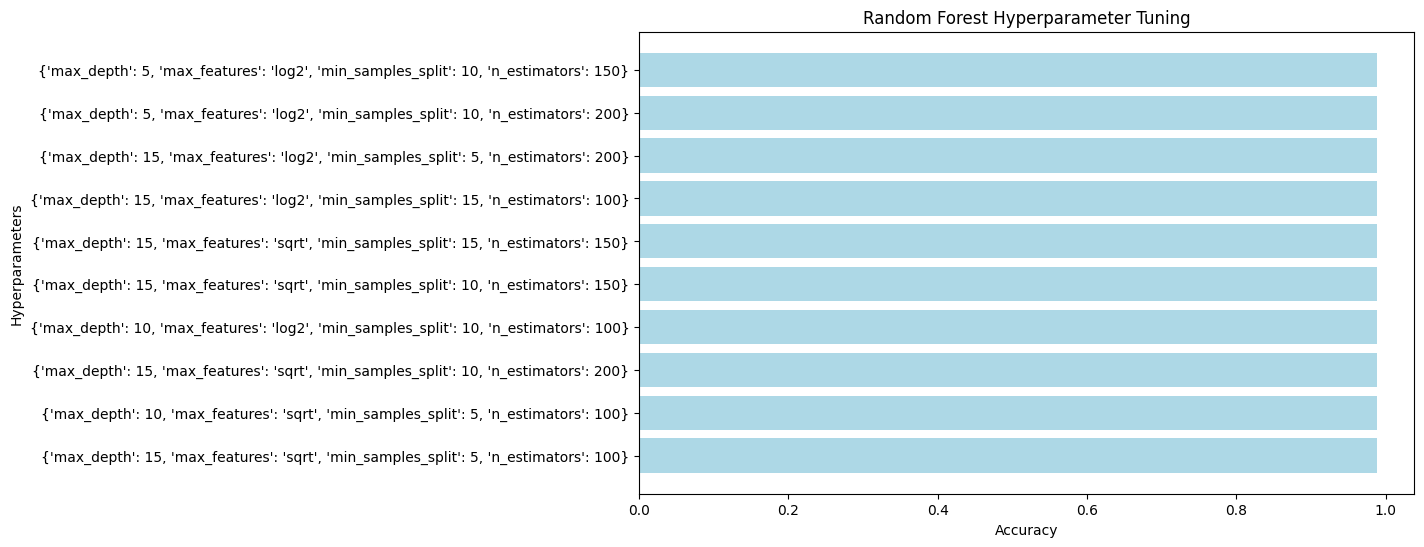

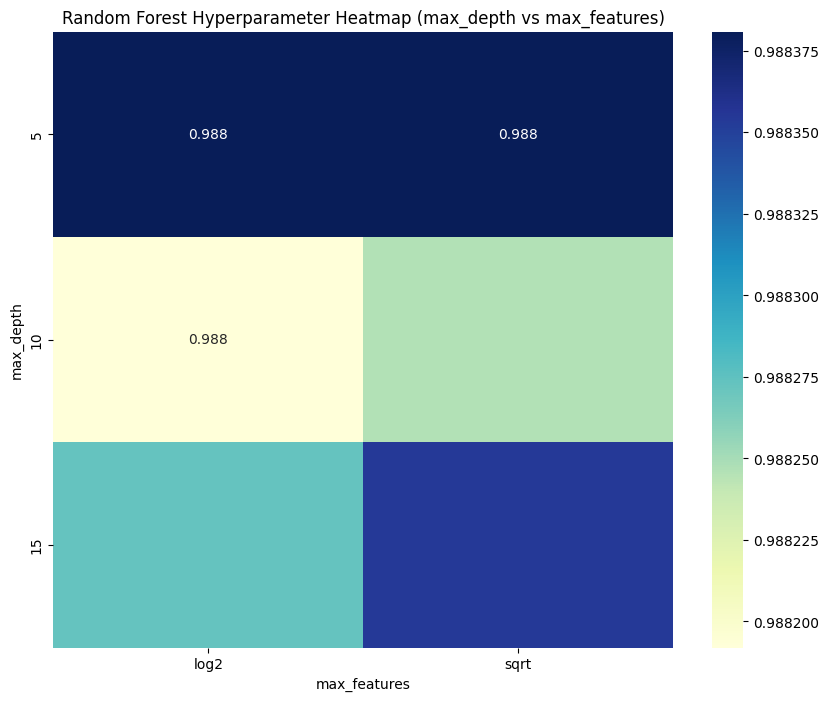

Best hyperparameters for Random Forest: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 100}
Random Forest 80% training split accuracy:  [0.99884484 0.99229891 0.9931096 ]
Random Forest 50% training split accuracy:  [0.99870298 0.99147211 0.99228275]
Random Forest 20% training split accuracy:  [0.9982166  0.98840828 0.99122487]


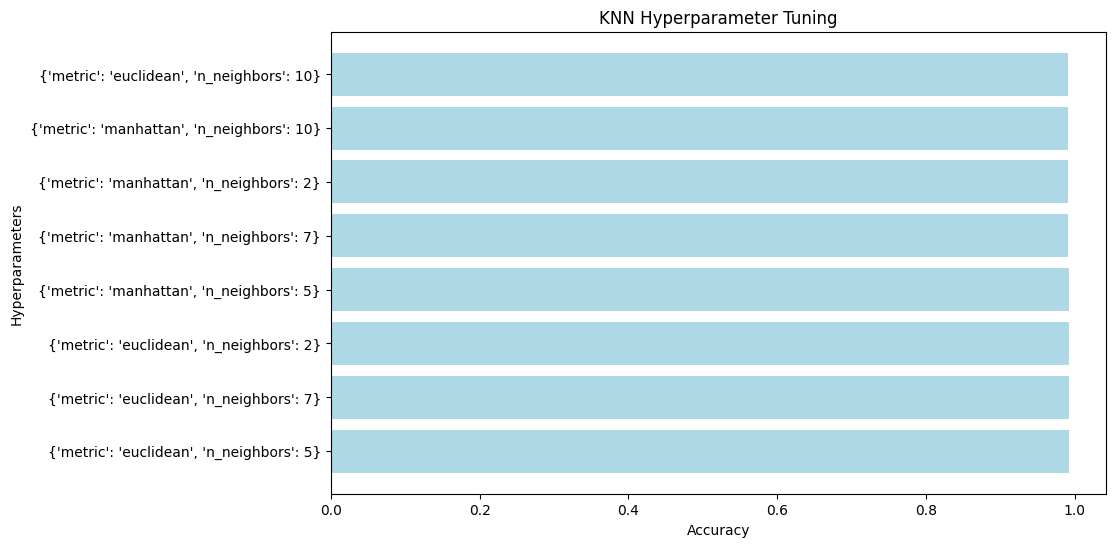

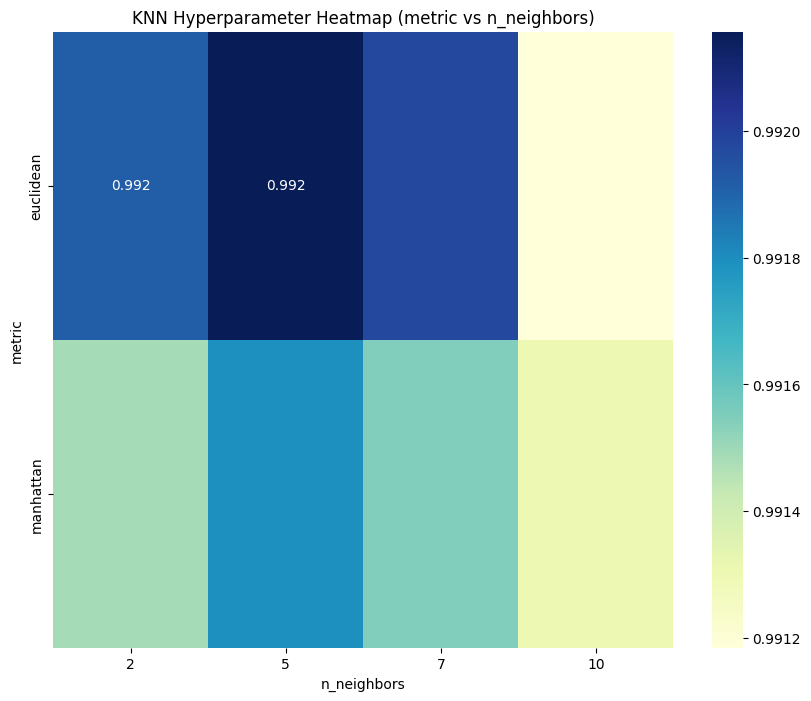

Best hyperparameters for KNN: {'metric': 'euclidean', 'n_neighbors': 5}


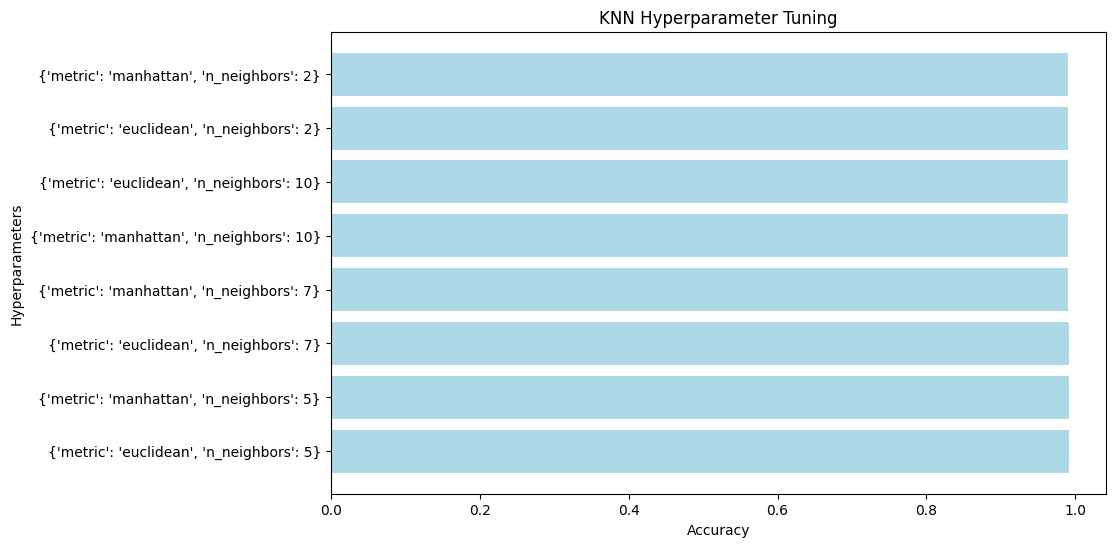

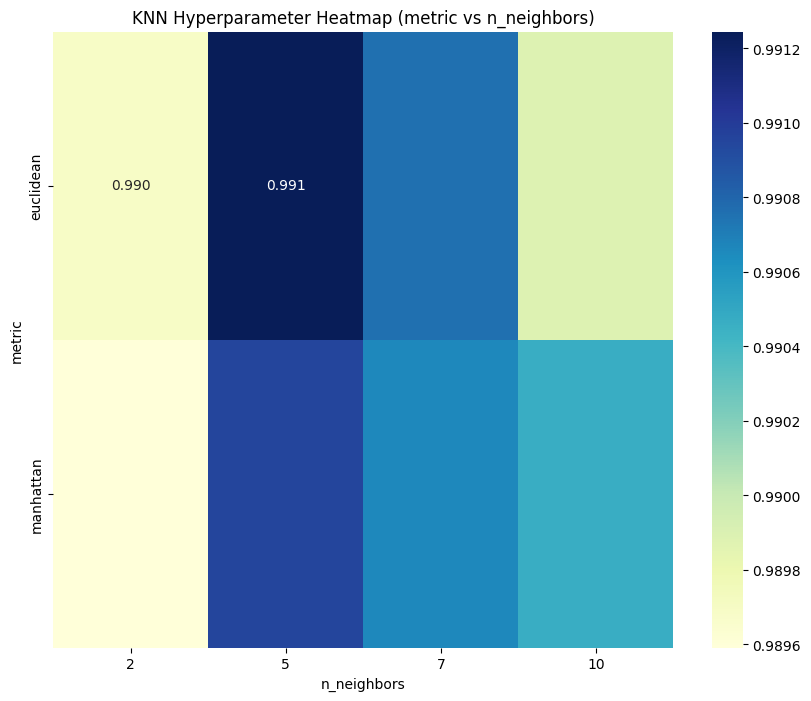

Best hyperparameters for KNN: {'metric': 'euclidean', 'n_neighbors': 5}


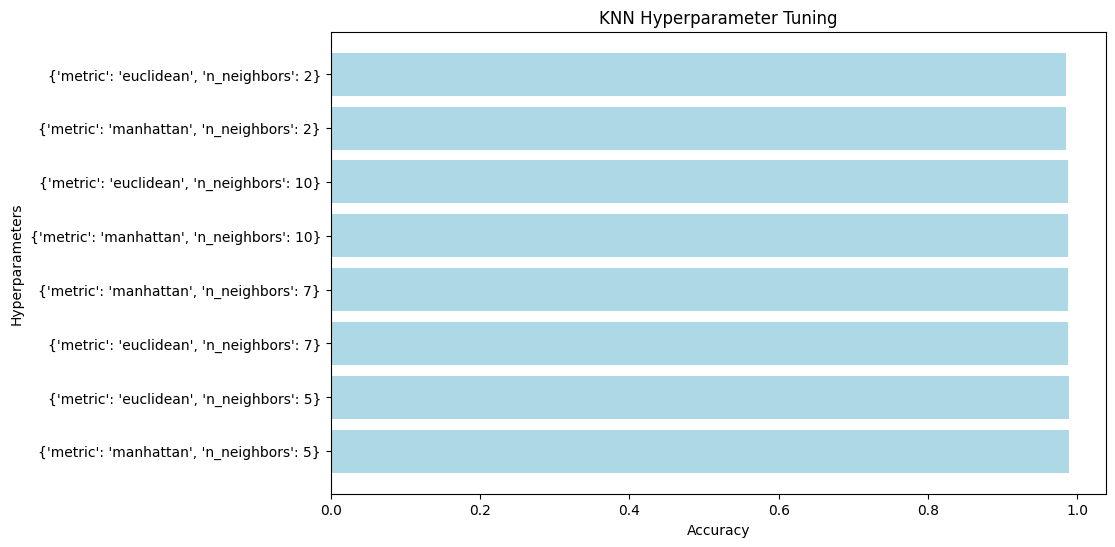

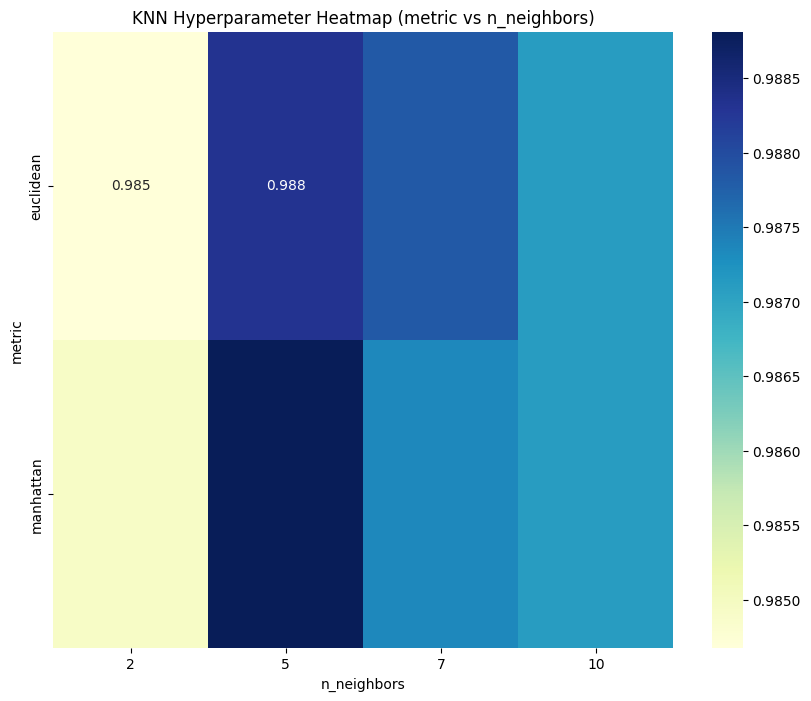

Best hyperparameters for KNN: {'metric': 'manhattan', 'n_neighbors': 5}
--------------------------------------------------------------------
KNN 80% training split accuracy:  [0.99440661 0.99215711 0.99392023]
KNN 50% training split accuracy:  [0.9938716  0.99124514 0.99192607]
KNN 20% training split accuracy:  [0.99027237 0.98881311 0.99008998]


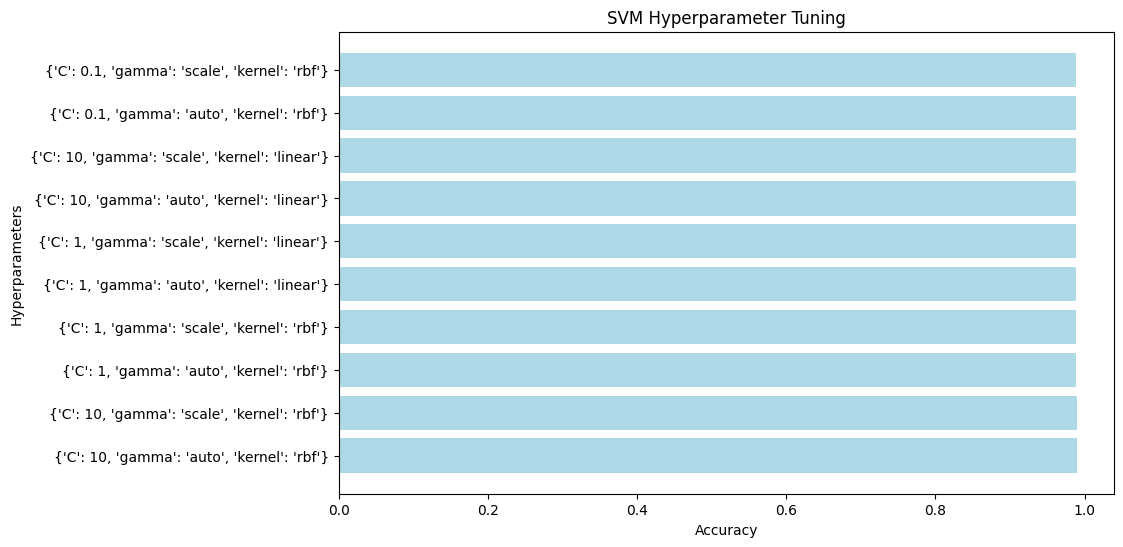

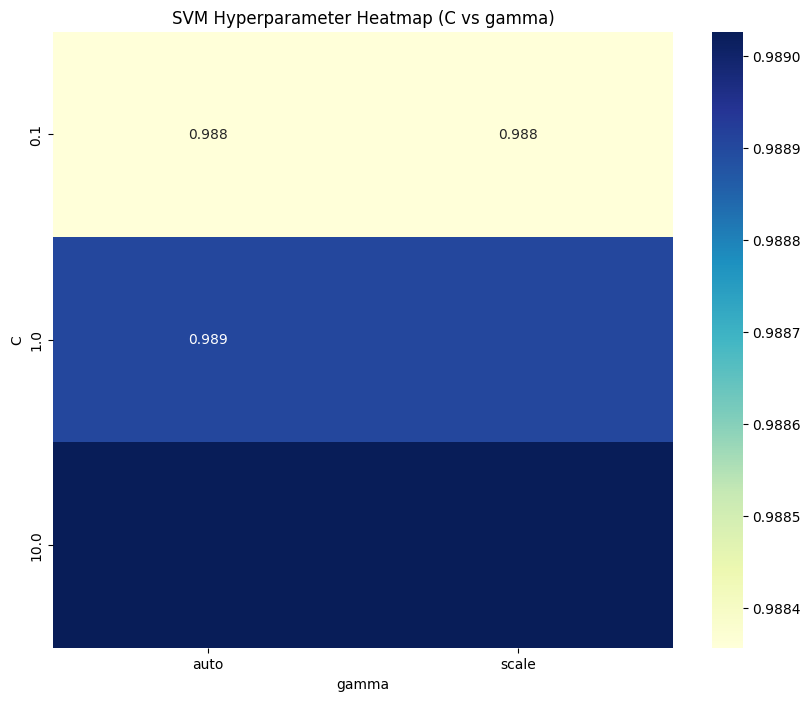

Best hyperparameters for SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


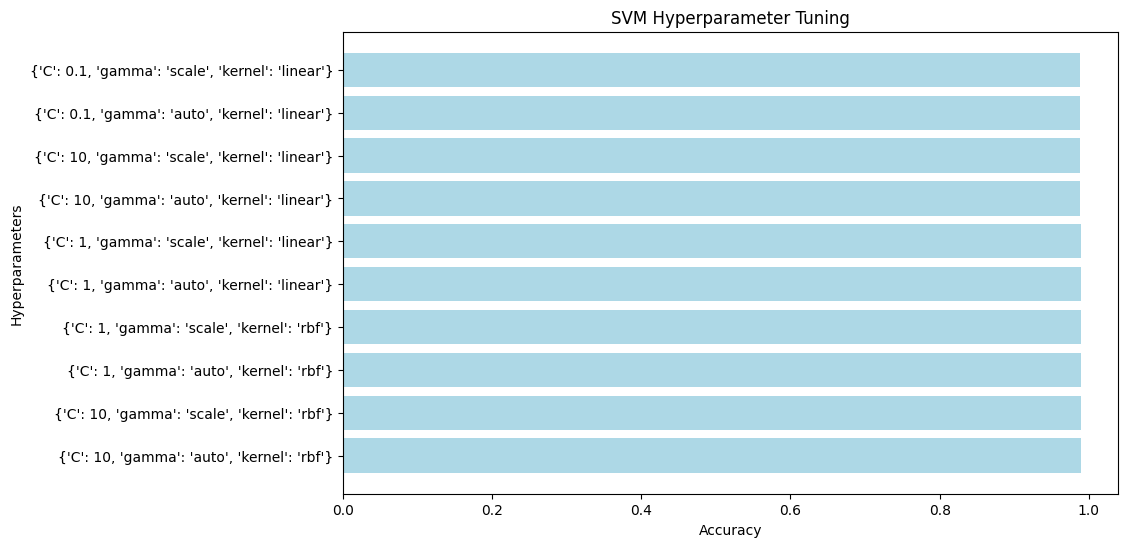

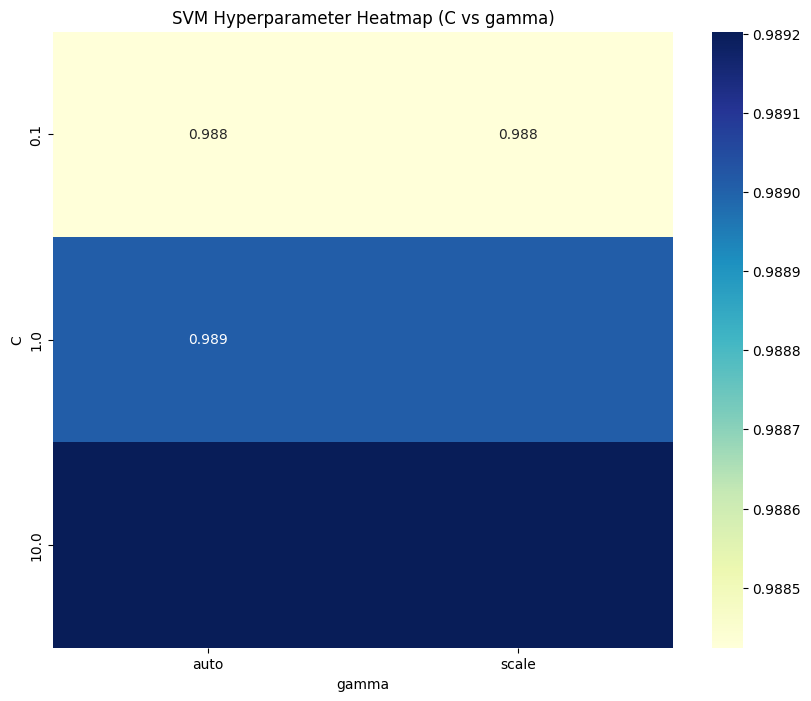

Best hyperparameters for SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


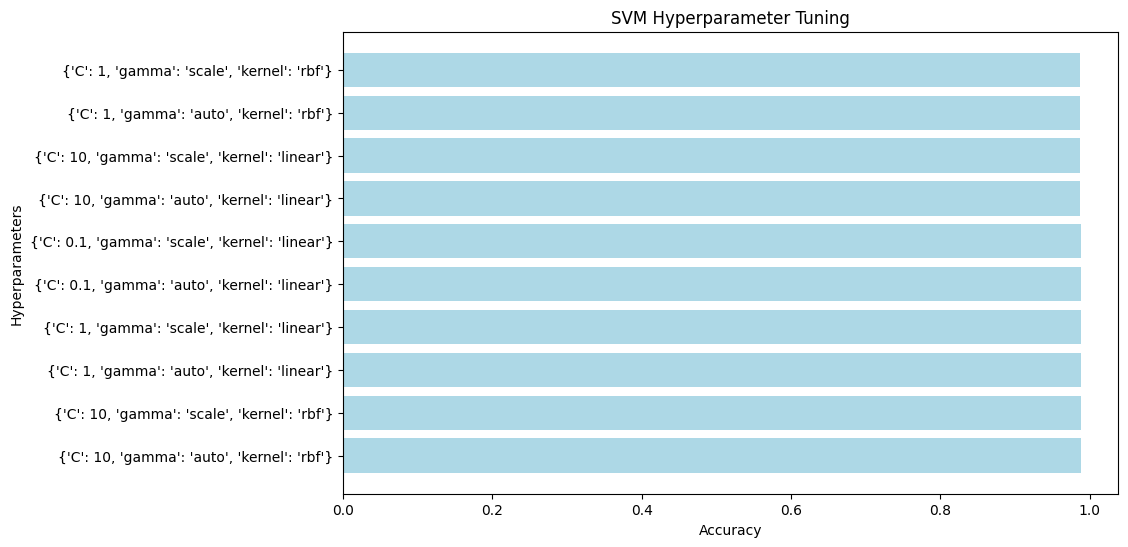

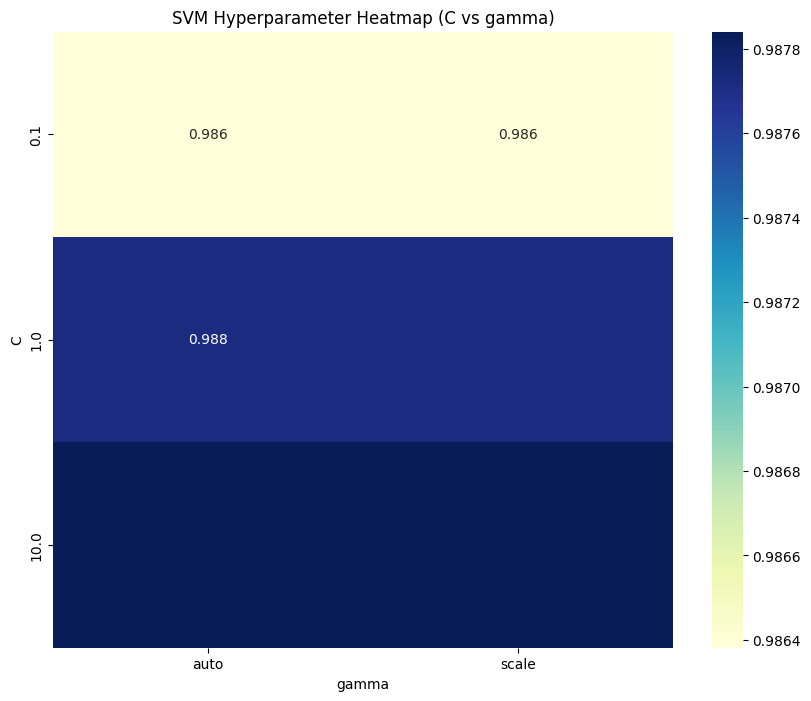

Best hyperparameters for SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
--------------------------------------------------------------------
SVM 80% training split accuracy:  [0.98972519 0.98960346 0.99002918]
SVM 50% training split accuracy:  [0.98998054 0.98968872 0.98959144]
SVM 20% training split accuracy:  [0.98881323 0.98832708 0.98984679]


In [9]:
#all models for occupancy dataset
rf_80_occ, rf_80_occ_acc = rf_fit(X_occ, y_occ, 0.2)
rf_50_occ, rf_50_occ_acc = rf_fit(X_occ, y_occ, 0.5)
rf_20_occ, rf_20_occ_acc = rf_fit(X_occ, y_occ, 0.8)

print("Random Forest 80% training split accuracy: ", rf_80_occ_acc)
print("Random Forest 50% training split accuracy: ", rf_50_occ_acc)
print("Random Forest 20% training split accuracy: ", rf_20_occ_acc)

knn_80_occ, knn_80_occ_acc = knn_fit(X_occ, y_occ, 0.2)
knn_50_occ, knn_50_occ_acc = knn_fit(X_occ, y_occ, 0.5)
knn_20_occ, knn_20_occ_acc = knn_fit(X_occ, y_occ, 0.8)

print("--------------------------------------------------------------------")
print("KNN 80% training split accuracy: ", knn_80_occ_acc)
print("KNN 50% training split accuracy: ", knn_50_occ_acc)
print("KNN 20% training split accuracy: ", knn_20_occ_acc)

svm_80_occ, svm_80_occ_acc = svm_fit(X_occ, y_occ, 0.2)
svm_50_occ, svm_50_occ_acc = svm_fit(X_occ, y_occ, 0.5)
svm_20_occ, svm_20_occ_acc = svm_fit(X_occ, y_occ, 0.8)

print("--------------------------------------------------------------------")
print("SVM 80% training split accuracy: ", svm_80_occ_acc)
print("SVM 50% training split accuracy: ", svm_50_occ_acc)
print("SVM 20% training split accuracy: ", svm_20_occ_acc)

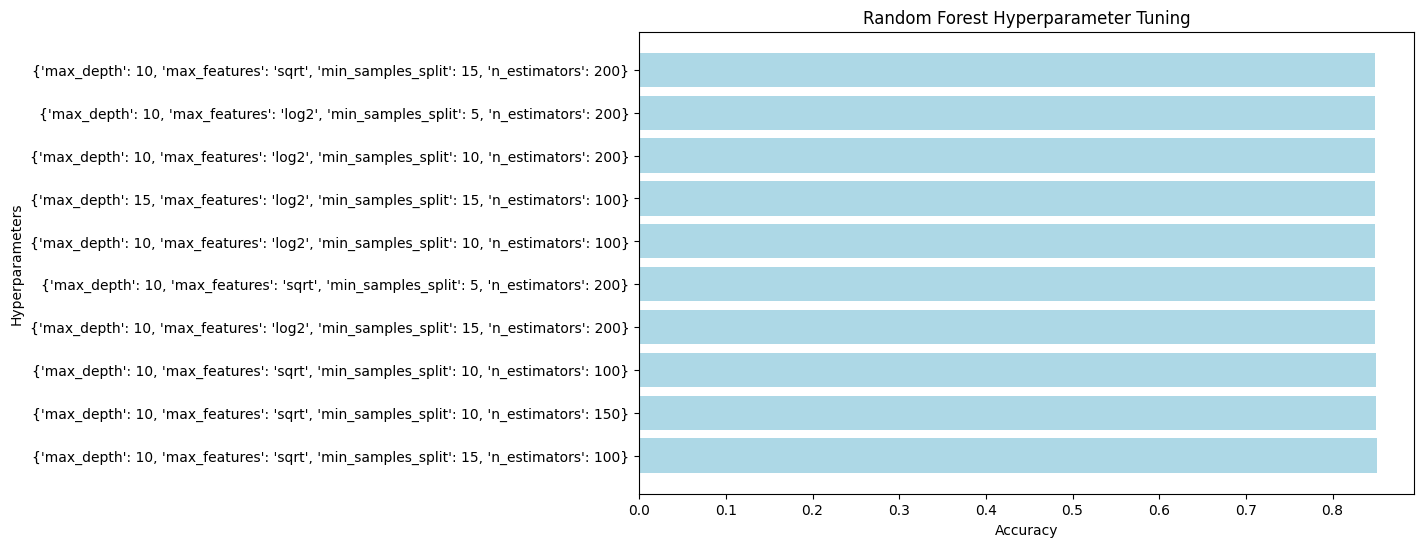

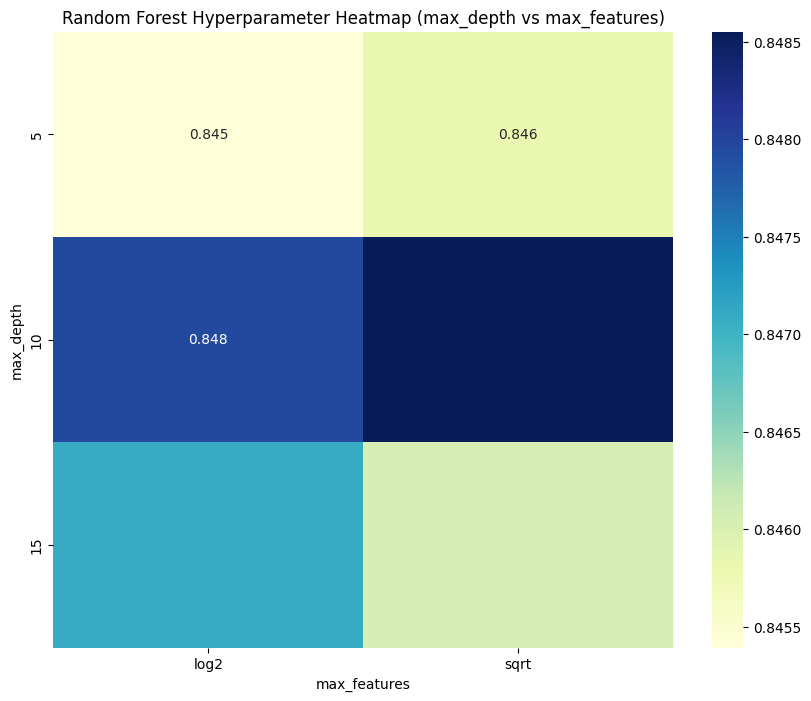

Best hyperparameters for Random Forest: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 15, 'n_estimators': 100}


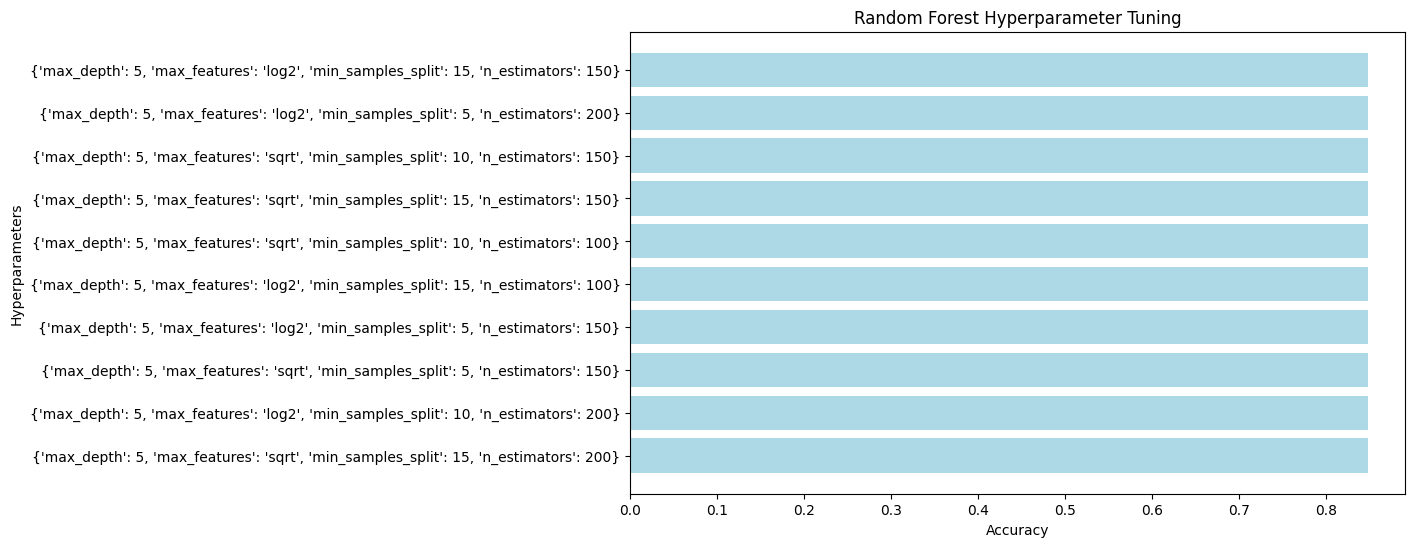

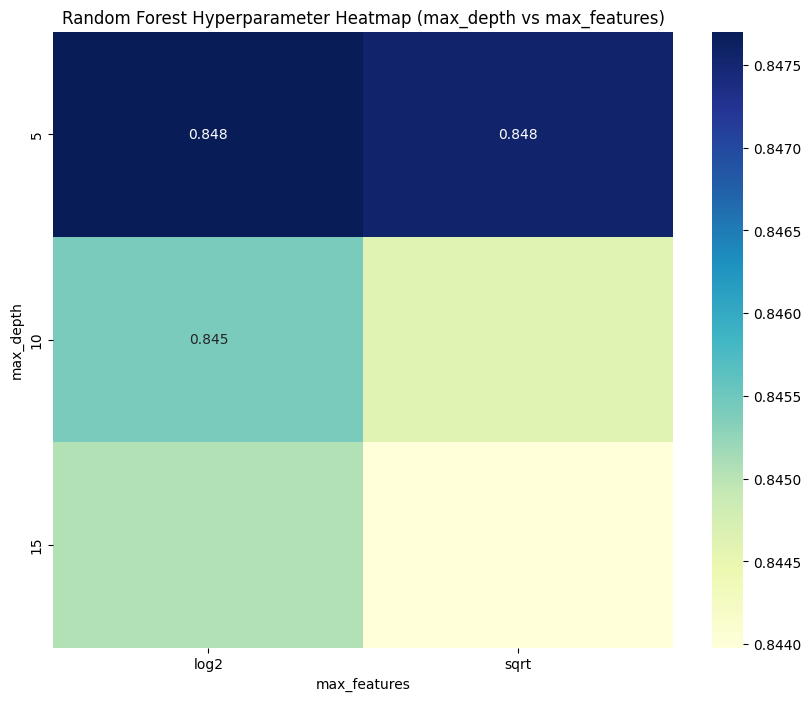

Best hyperparameters for Random Forest: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 15, 'n_estimators': 200}


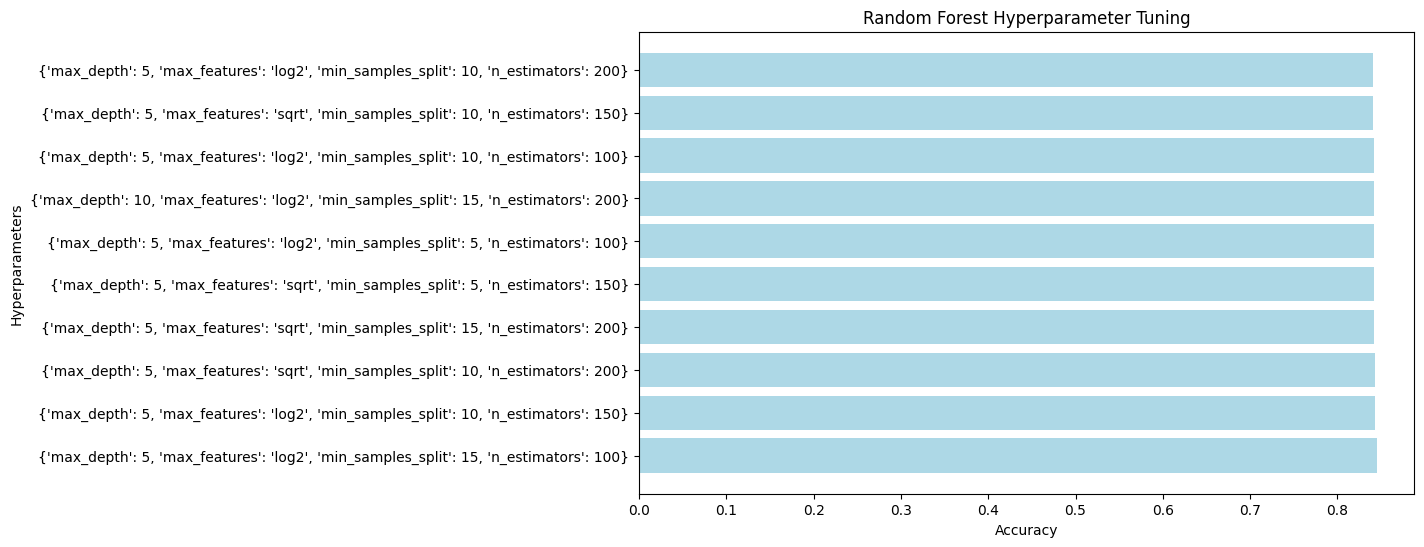

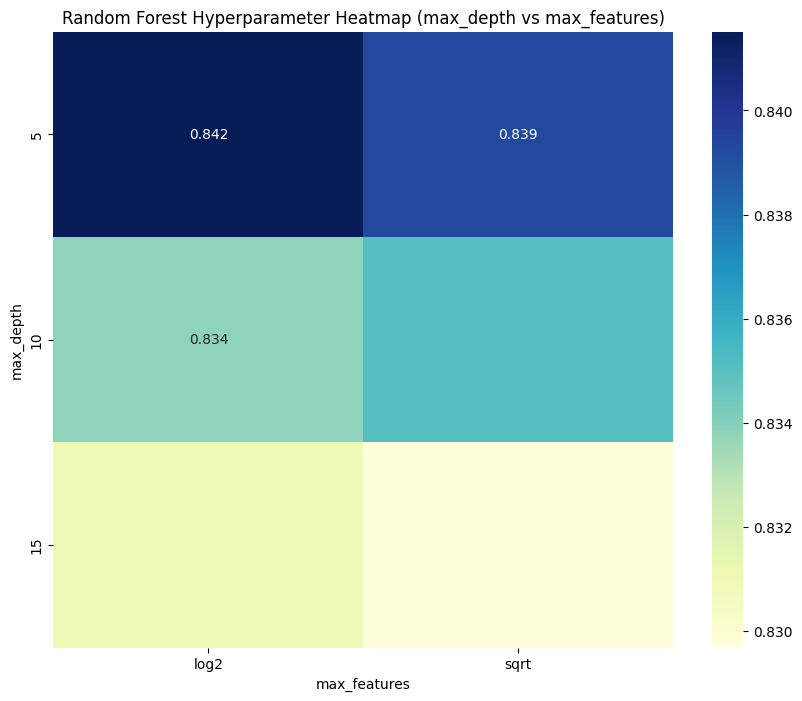

Best hyperparameters for Random Forest: {'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 15, 'n_estimators': 100}
Random Forest 80% training split accuracy:  [0.90970767 0.84845138 0.8476874 ]
Random Forest 50% training split accuracy:  [0.86318646 0.84722385 0.83995532]
Random Forest 20% training split accuracy:  [0.88383234 0.83992016 0.83772192]


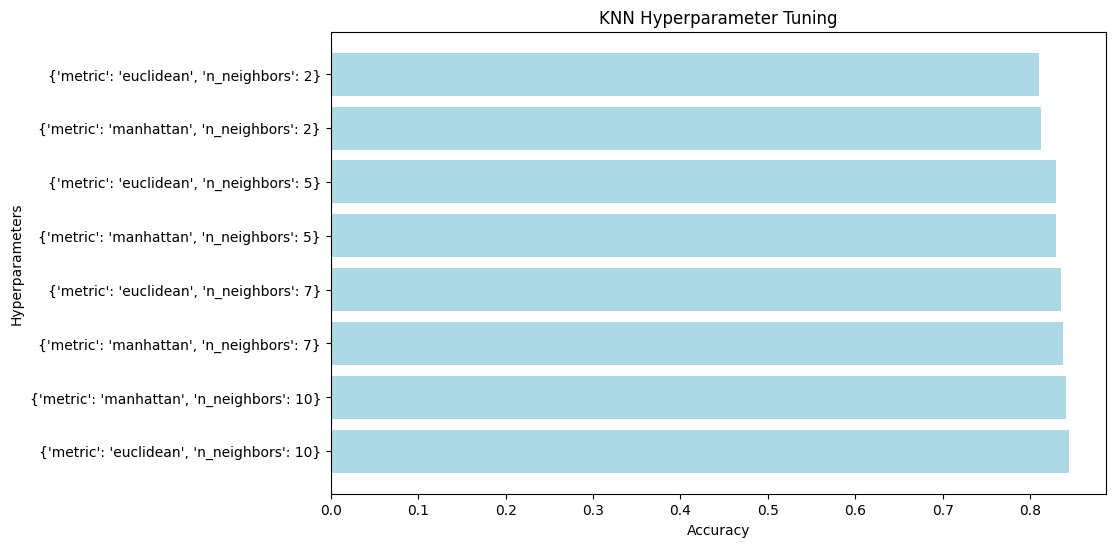

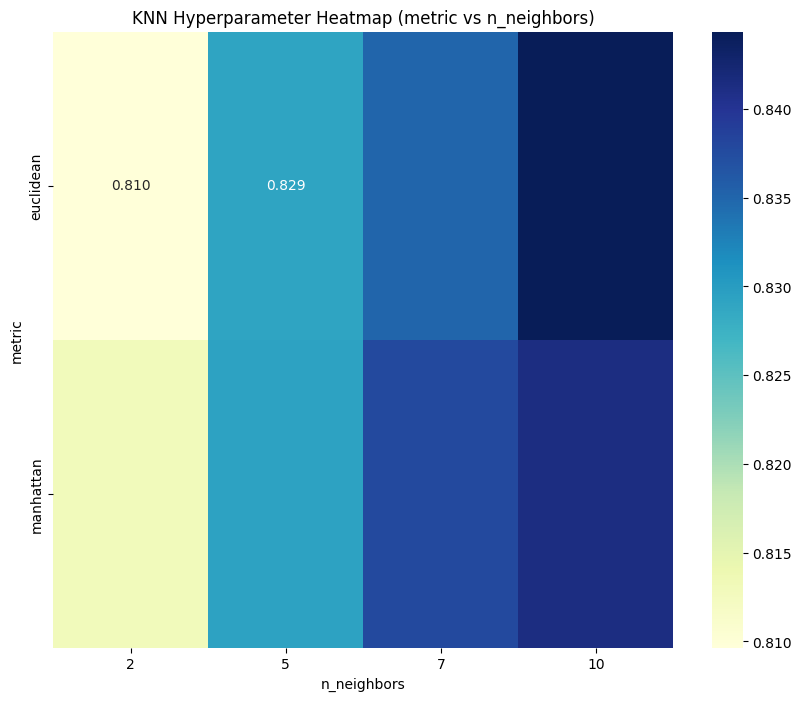

Best hyperparameters for KNN: {'metric': 'euclidean', 'n_neighbors': 10}


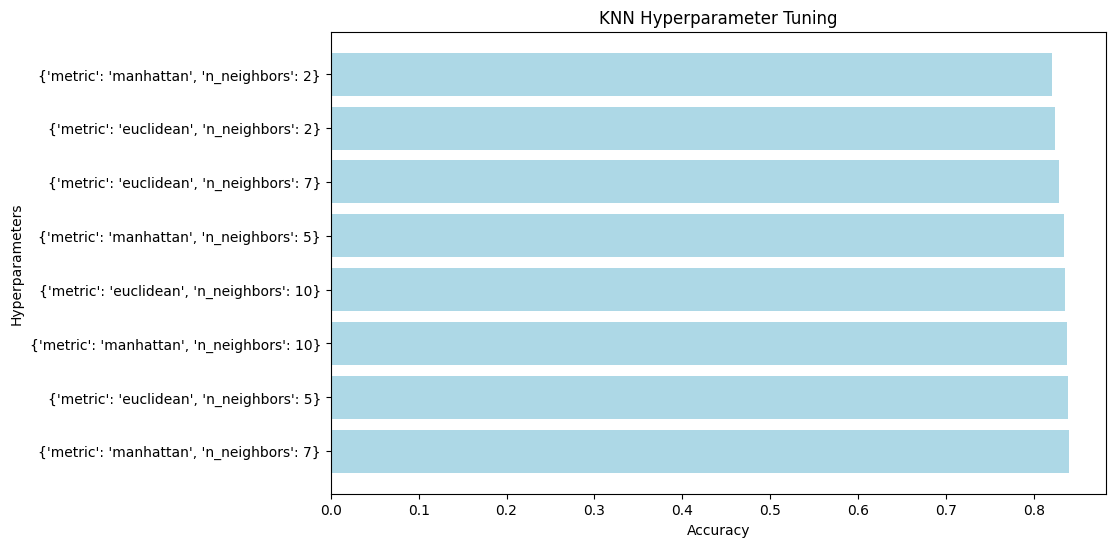

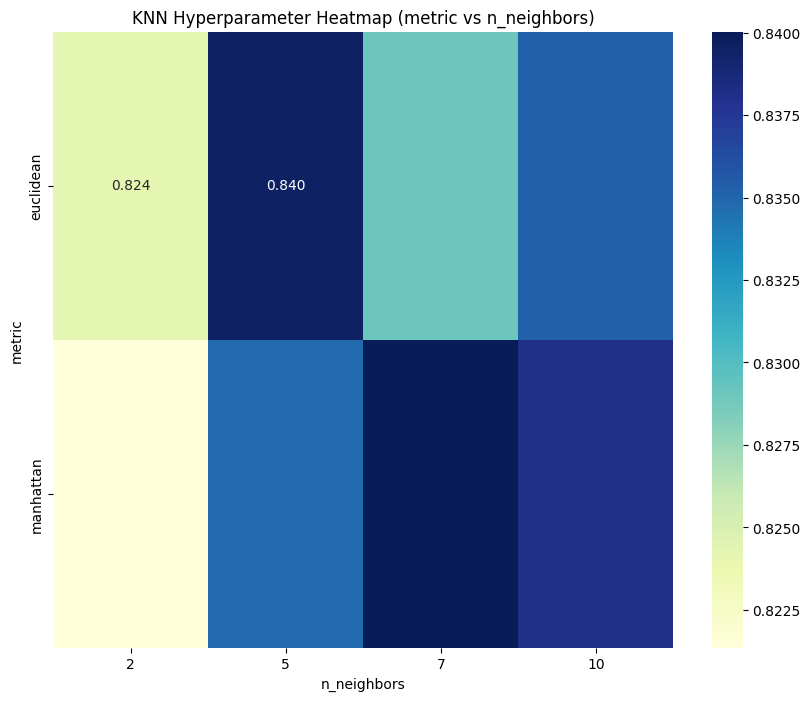

Best hyperparameters for KNN: {'metric': 'manhattan', 'n_neighbors': 7}


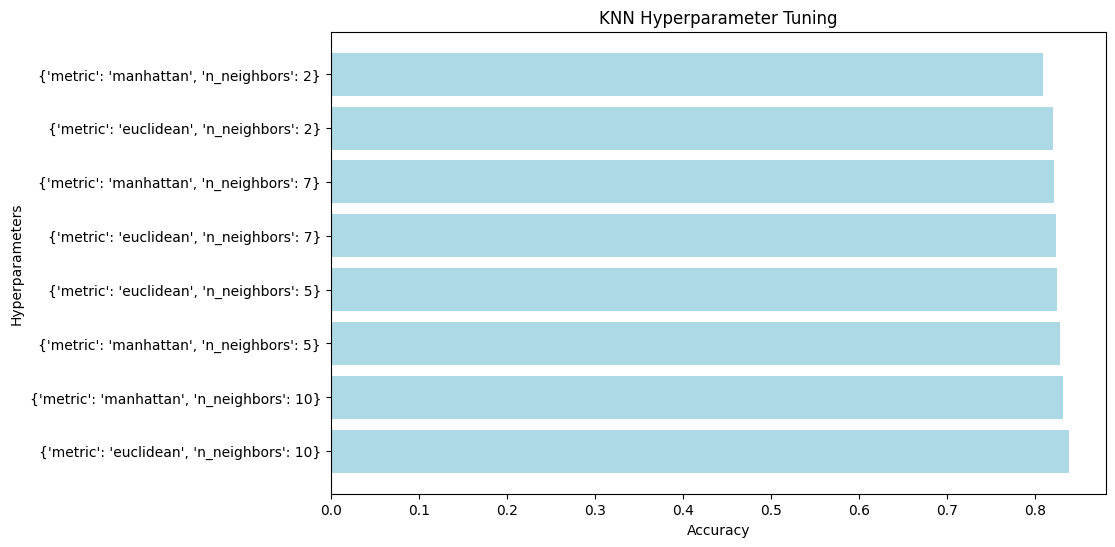

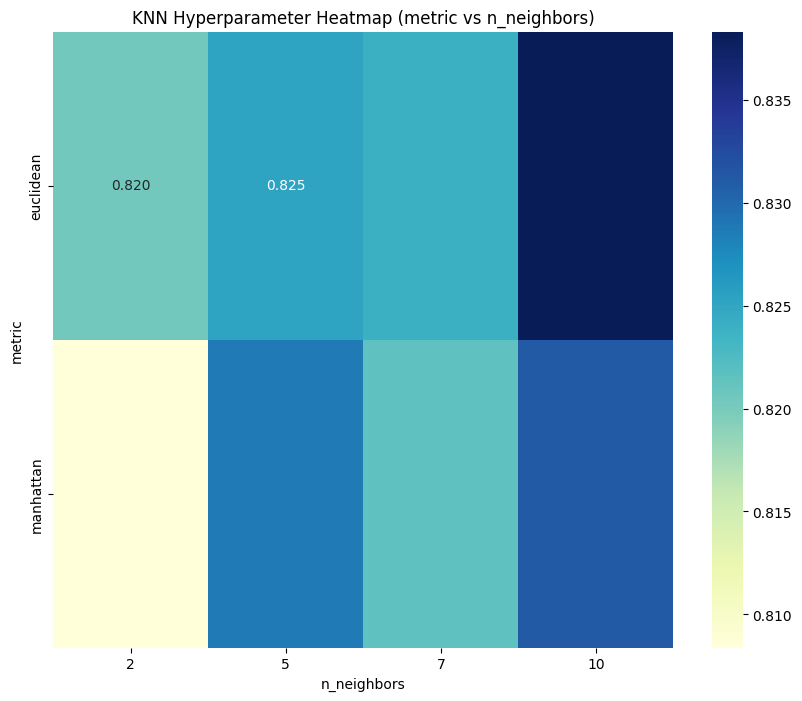

Best hyperparameters for KNN: {'metric': 'euclidean', 'n_neighbors': 10}
--------------------------------------------------------------------
KNN 80% training split accuracy:  [0.8656091  0.8443624  0.84808612]
KNN 50% training split accuracy:  [0.87643678 0.84003419 0.83963619]
KNN 20% training split accuracy:  [0.86107784 0.83832335 0.82465589]


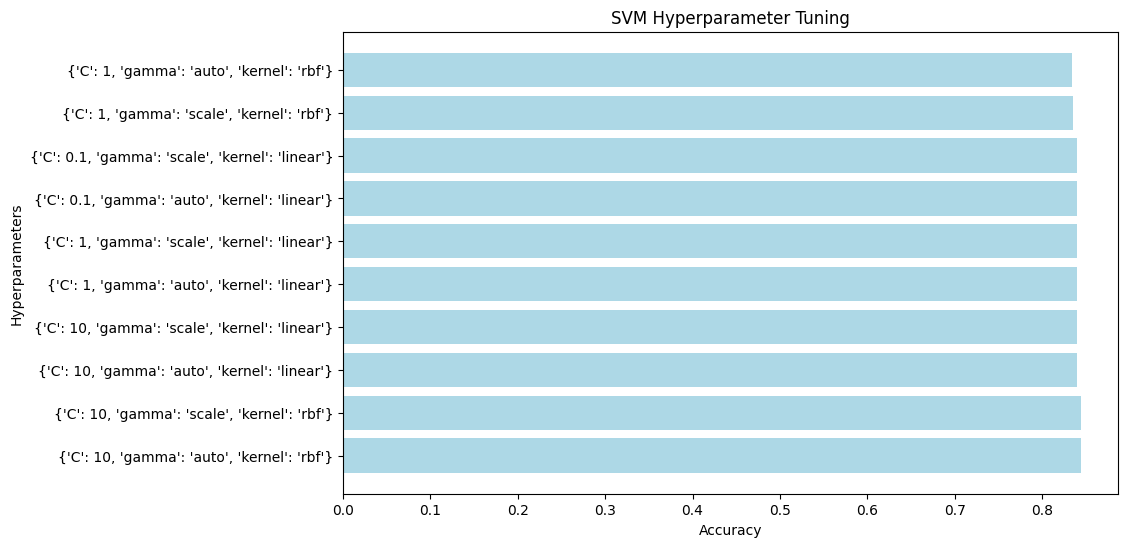

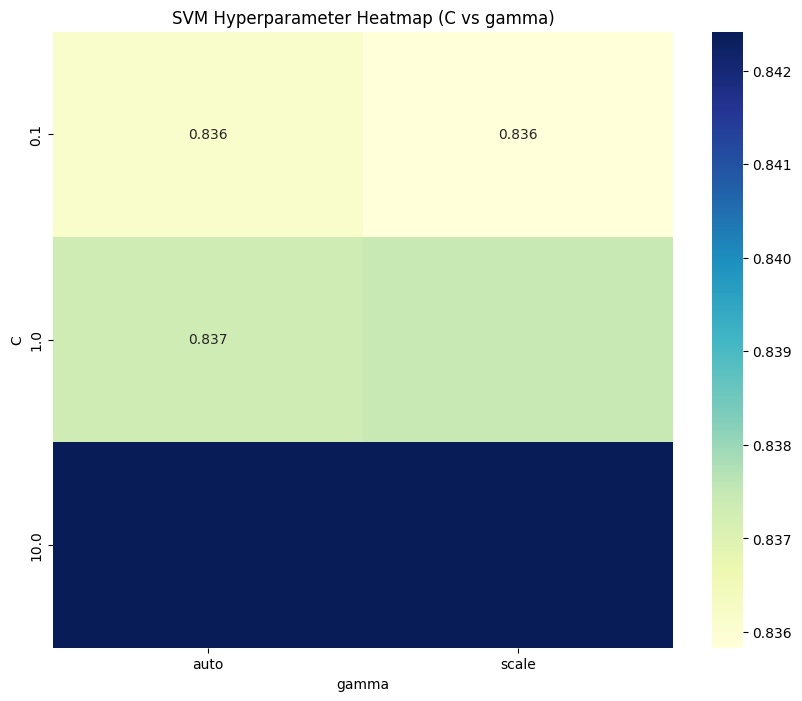

Best hyperparameters for SVM: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}


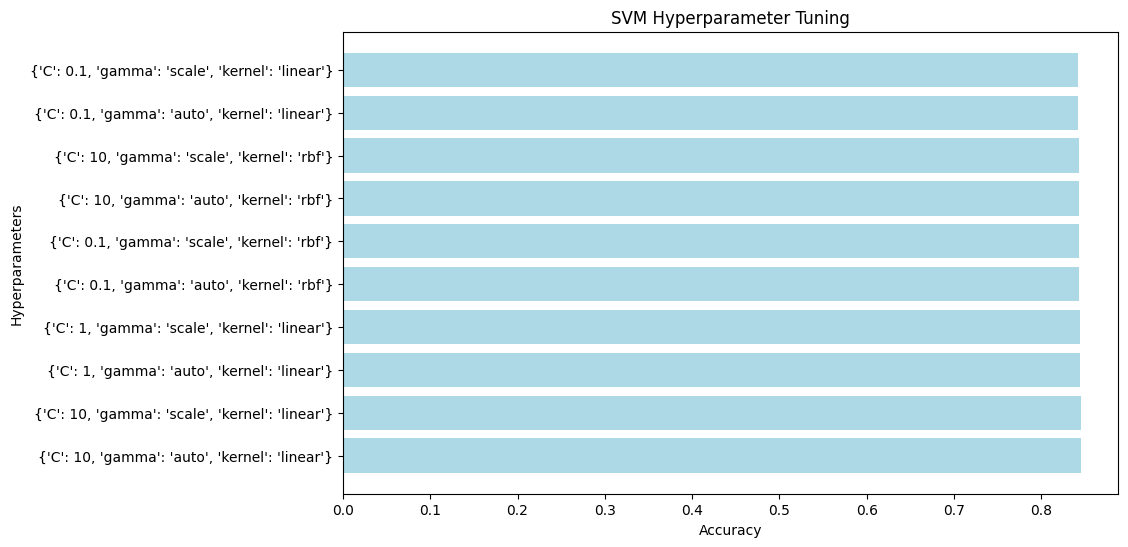

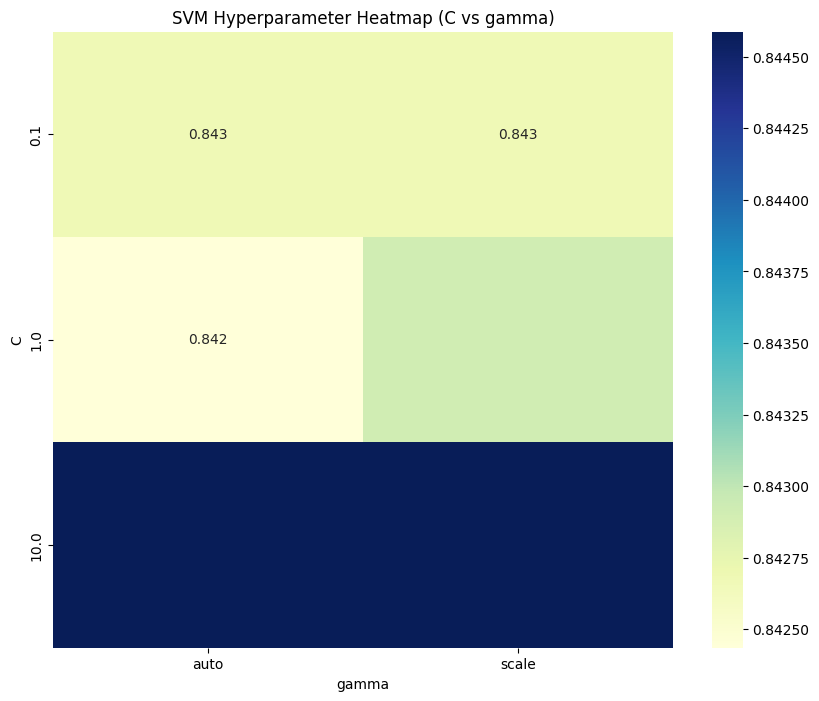

Best hyperparameters for SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}


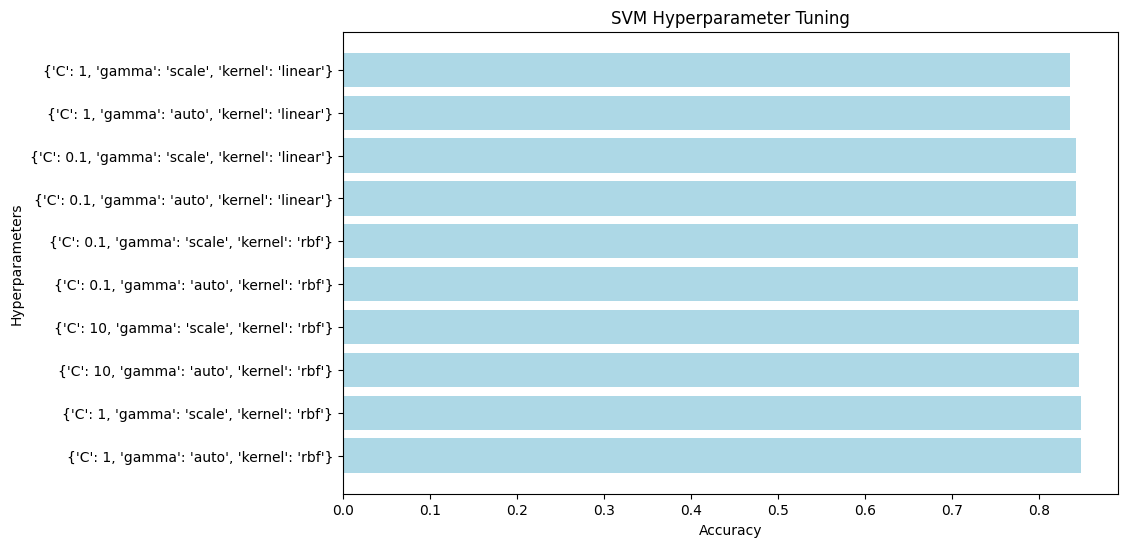

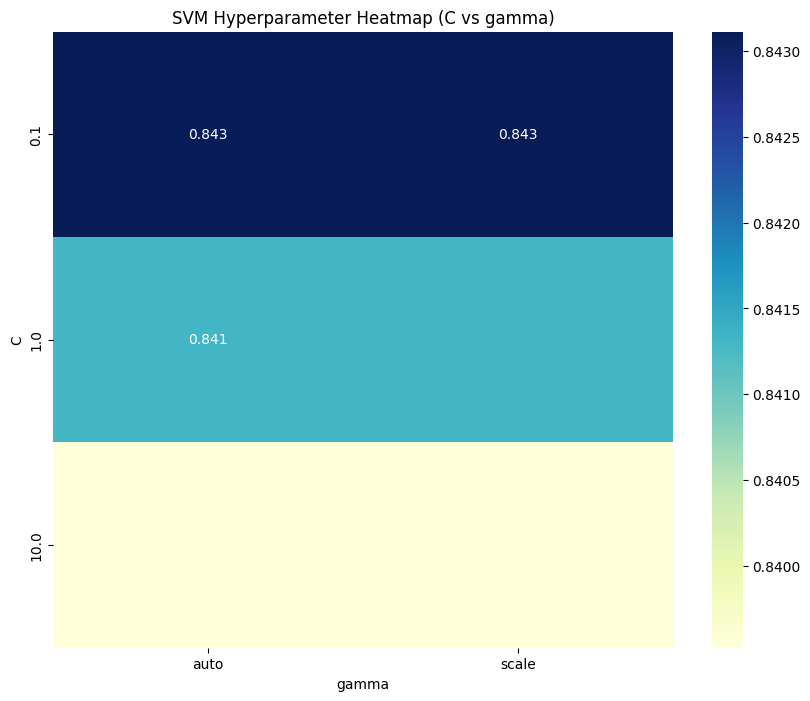

Best hyperparameters for SVM: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
--------------------------------------------------------------------
SVM 80% training split accuracy:  [0.85243939 0.84466359 0.85047847]
SVM 50% training split accuracy:  [0.84530651 0.84578615 0.83580661]
SVM 20% training split accuracy:  [0.8491018  0.84790419 0.83004189]


In [10]:
#all models for abalone dataset
rf_80_abal, rf_80_abal_acc = rf_fit(X_abal, y_abal, 0.2)
rf_50_abal, rf_50_abal_acc = rf_fit(X_abal, y_abal, 0.5)
rf_20_abal, rf_20_abal_acc = rf_fit(X_abal, y_abal, 0.8)

print("Random Forest 80% training split accuracy: ", rf_80_abal_acc)
print("Random Forest 50% training split accuracy: ", rf_50_abal_acc)
print("Random Forest 20% training split accuracy: ", rf_20_abal_acc)

knn_80_abal, knn_80_abal_acc = knn_fit(X_abal, y_abal, 0.2)
knn_50_abal, knn_50_abal_acc = knn_fit(X_abal, y_abal, 0.5)
knn_20_abal, knn_20_abal_acc = knn_fit(X_abal, y_abal, 0.8)

print("--------------------------------------------------------------------")
print("KNN 80% training split accuracy: ", knn_80_abal_acc)
print("KNN 50% training split accuracy: ", knn_50_abal_acc)
print("KNN 20% training split accuracy: ", knn_20_abal_acc)

svm_80_abal, svm_80_abal_acc = svm_fit(X_abal, y_abal, 0.2)
svm_50_abal, svm_50_abal_acc = svm_fit(X_abal, y_abal, 0.5)
svm_20_abal, svm_20_abal_acc = svm_fit(X_abal, y_abal, 0.8)

print("--------------------------------------------------------------------")
print("SVM 80% training split accuracy: ", svm_80_abal_acc)
print("SVM 50% training split accuracy: ", svm_50_abal_acc)
print("SVM 20% training split accuracy: ", svm_20_abal_acc)

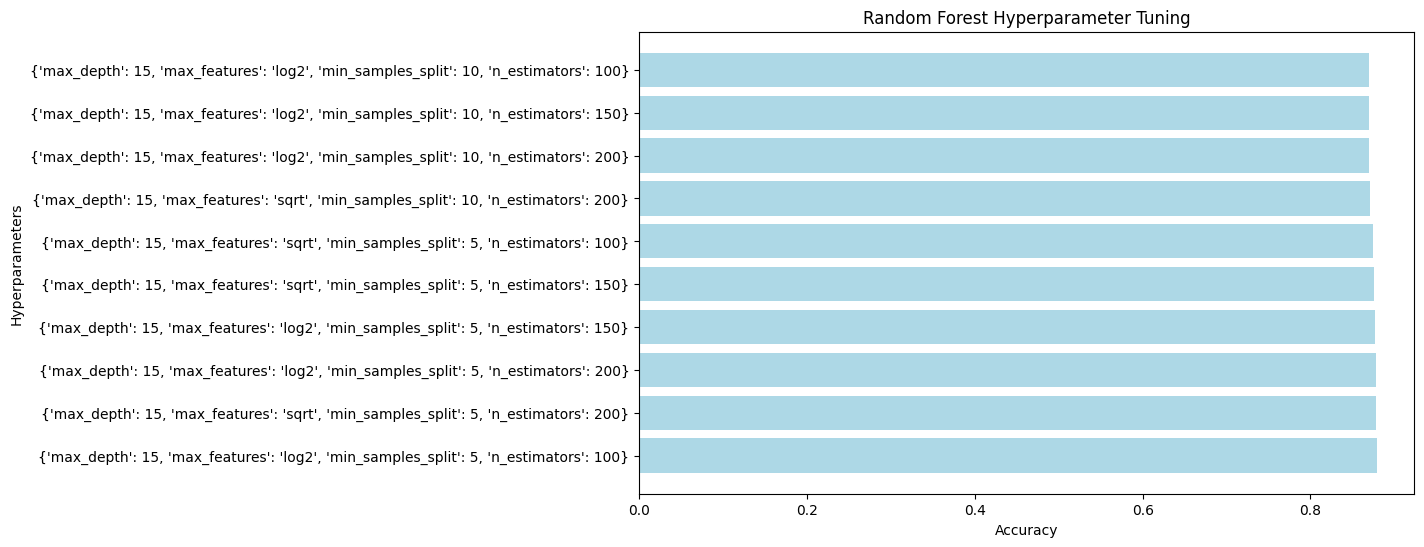

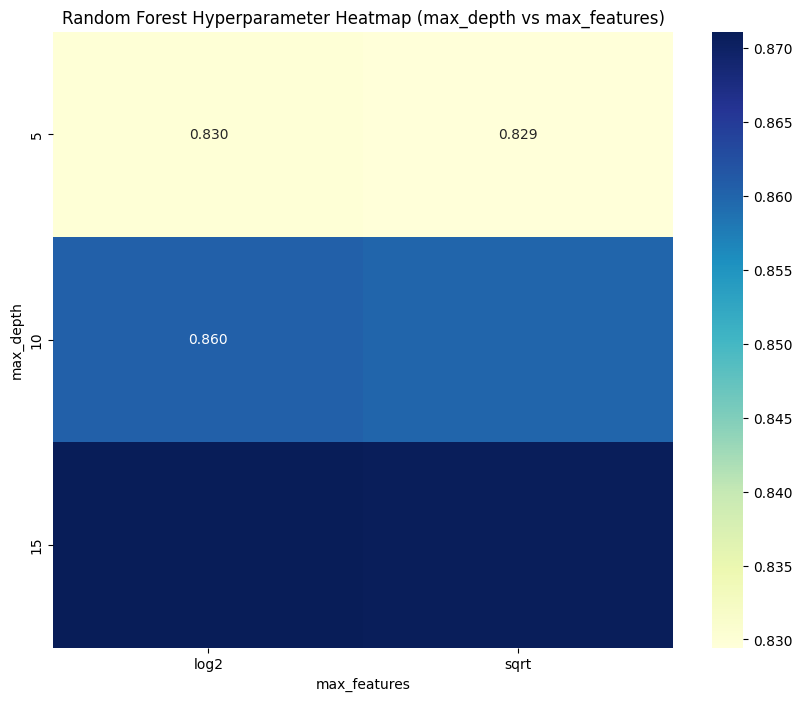

Best hyperparameters for Random Forest: {'max_depth': 15, 'max_features': 'log2', 'min_samples_split': 5, 'n_estimators': 100}


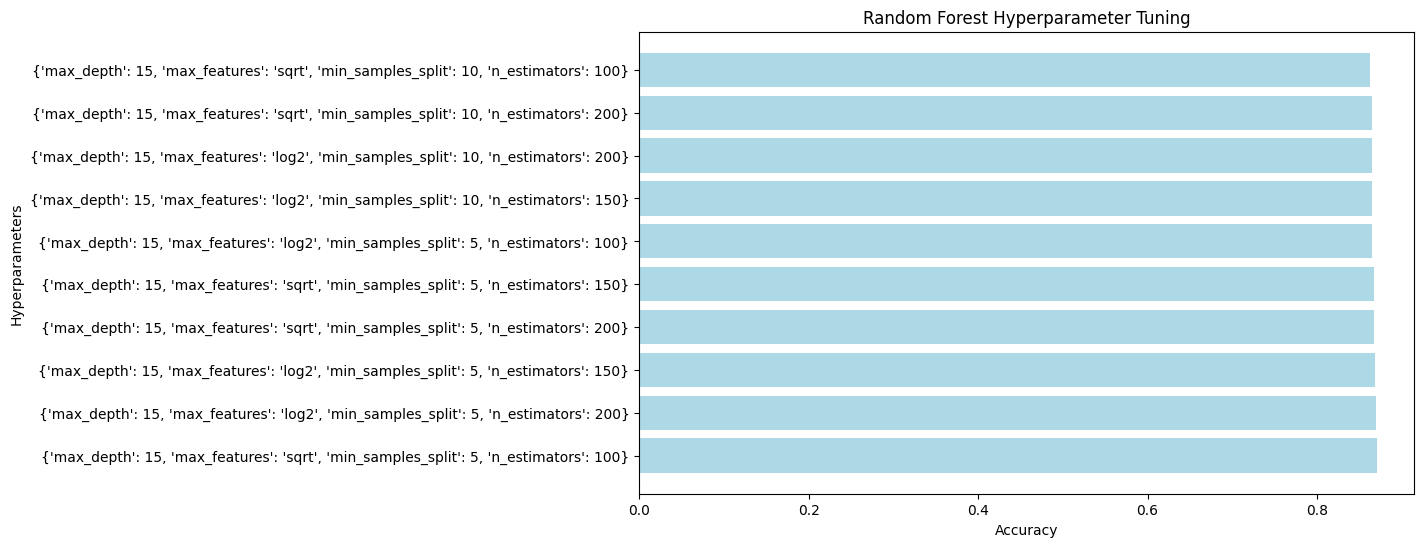

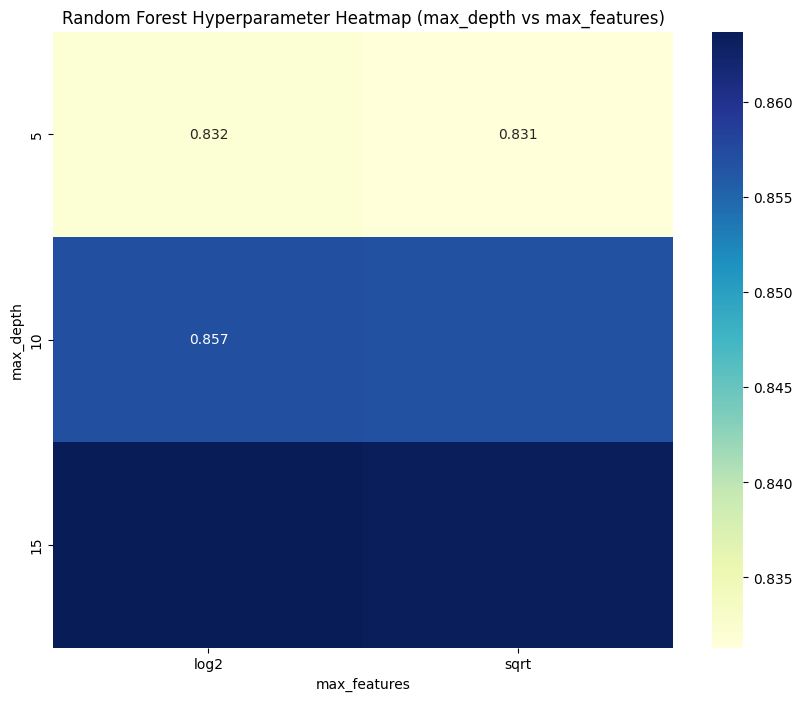

Best hyperparameters for Random Forest: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 100}


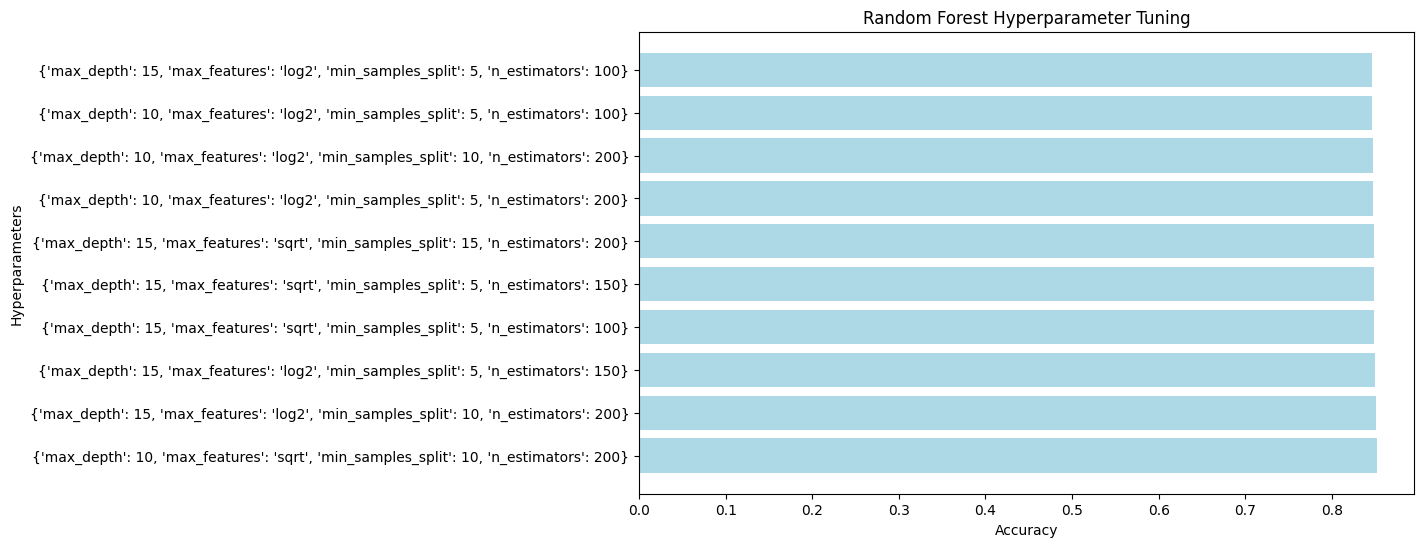

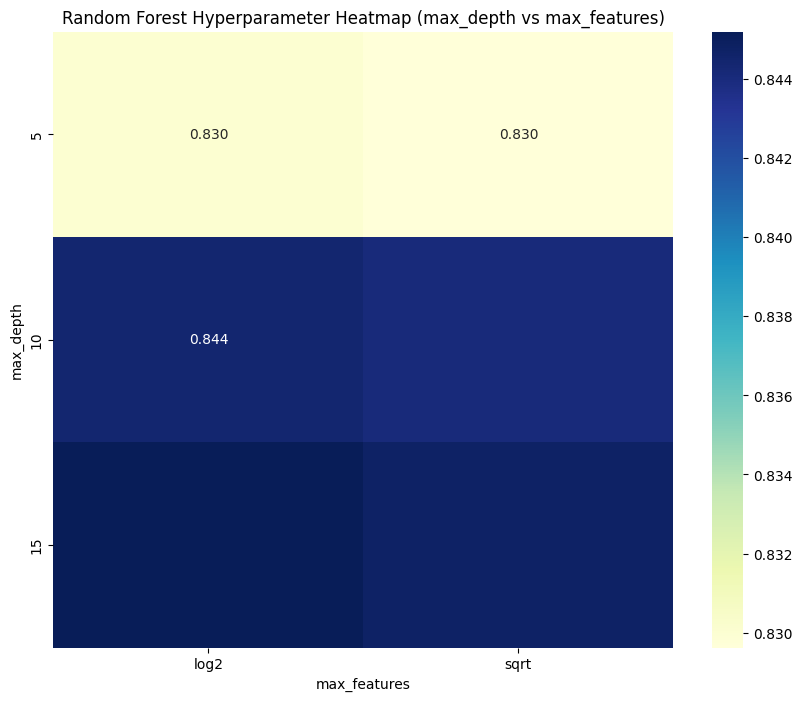

Best hyperparameters for Random Forest: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 200}
Random Forest 80% training split accuracy:  [0.99012251 0.87589164 0.88051282]
Random Forest 50% training split accuracy:  [0.99025041 0.86719972 0.86088027]
Random Forest 20% training split accuracy:  [0.94790865 0.84553807 0.83756573]


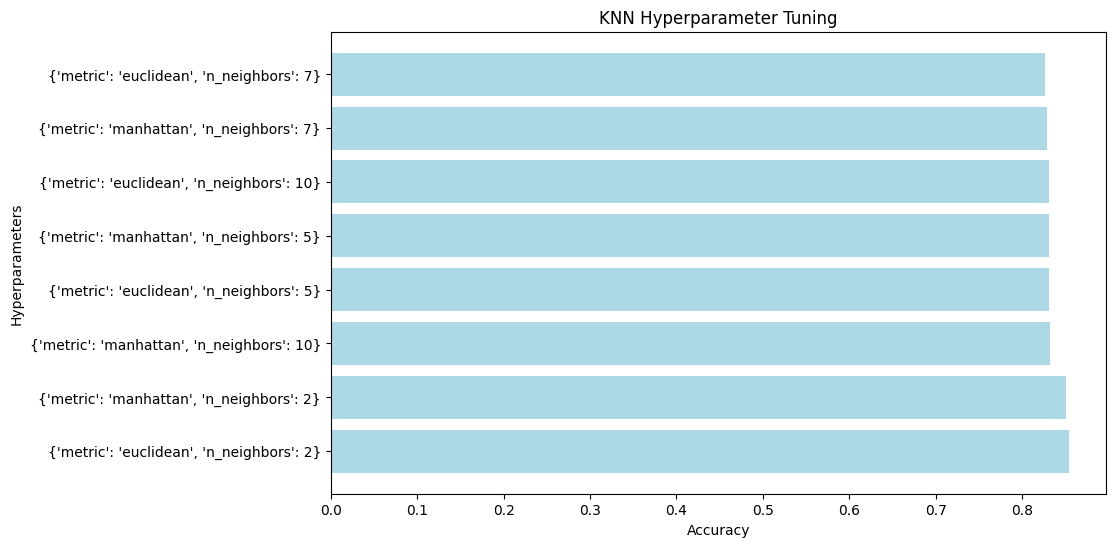

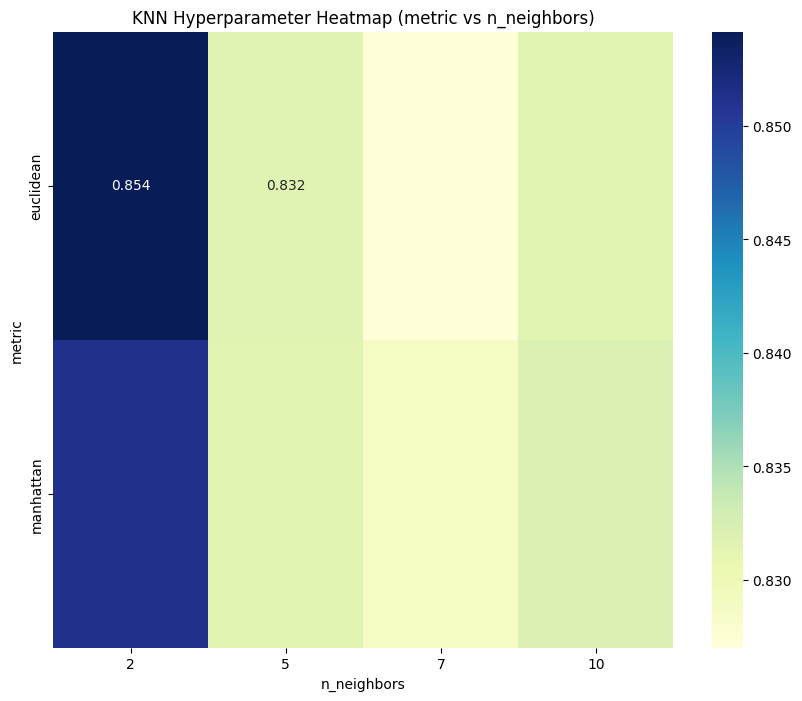

Best hyperparameters for KNN: {'metric': 'euclidean', 'n_neighbors': 2}


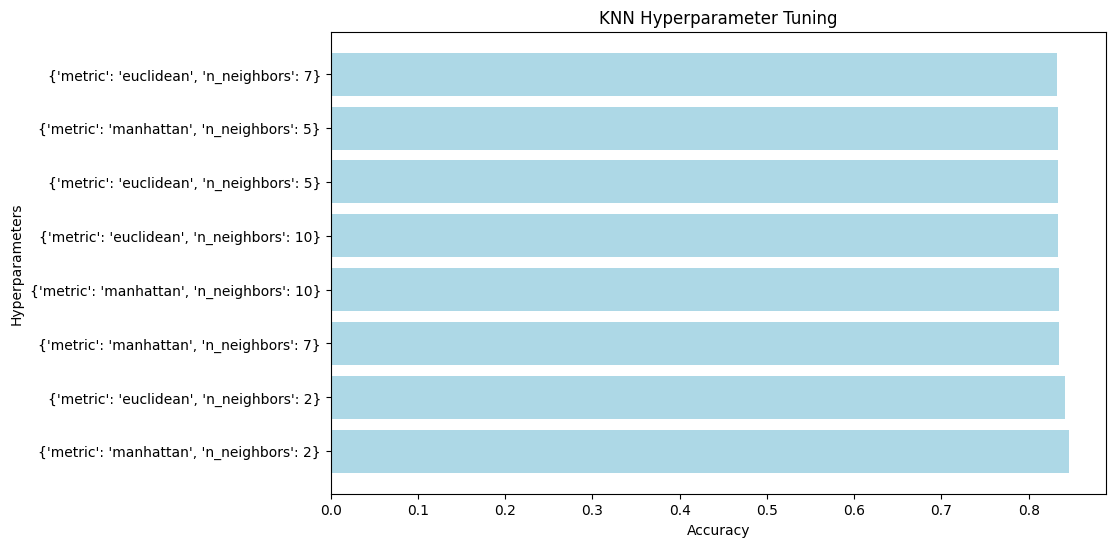

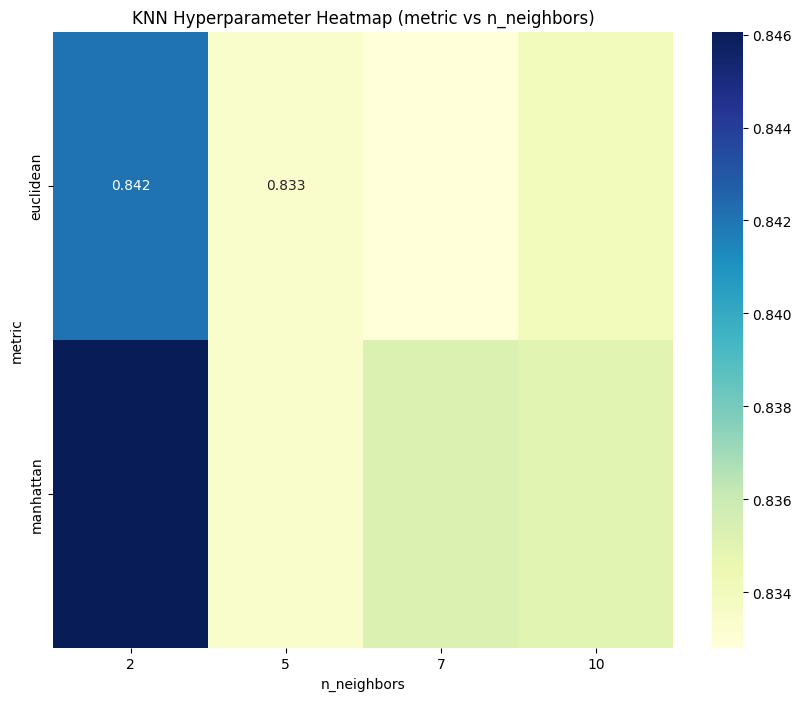

Best hyperparameters for KNN: {'metric': 'manhattan', 'n_neighbors': 2}


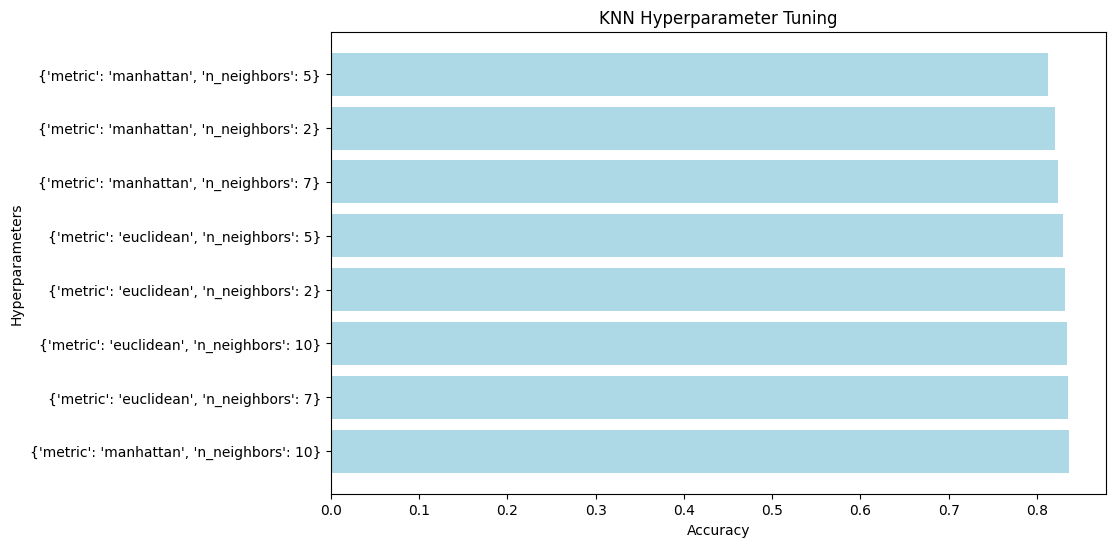

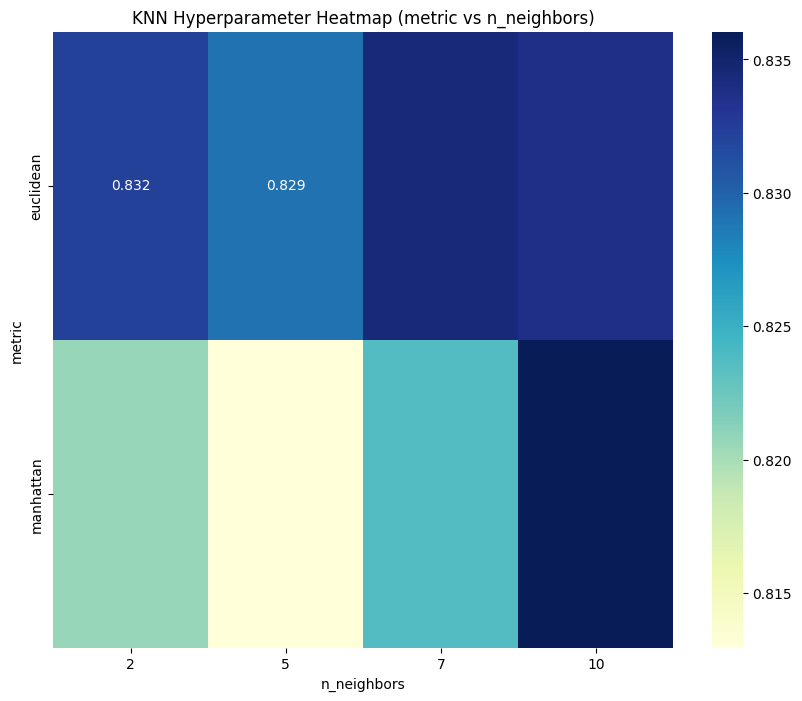

Best hyperparameters for KNN: {'metric': 'manhattan', 'n_neighbors': 10}
--------------------------------------------------------------------
KNN 80% training split accuracy:  [0.93092169 0.85414896 0.83846154]
KNN 50% training split accuracy:  [0.92456897 0.84606329 0.83625731]
KNN 20% training split accuracy:  [0.84834488 0.83603802 0.82204694]


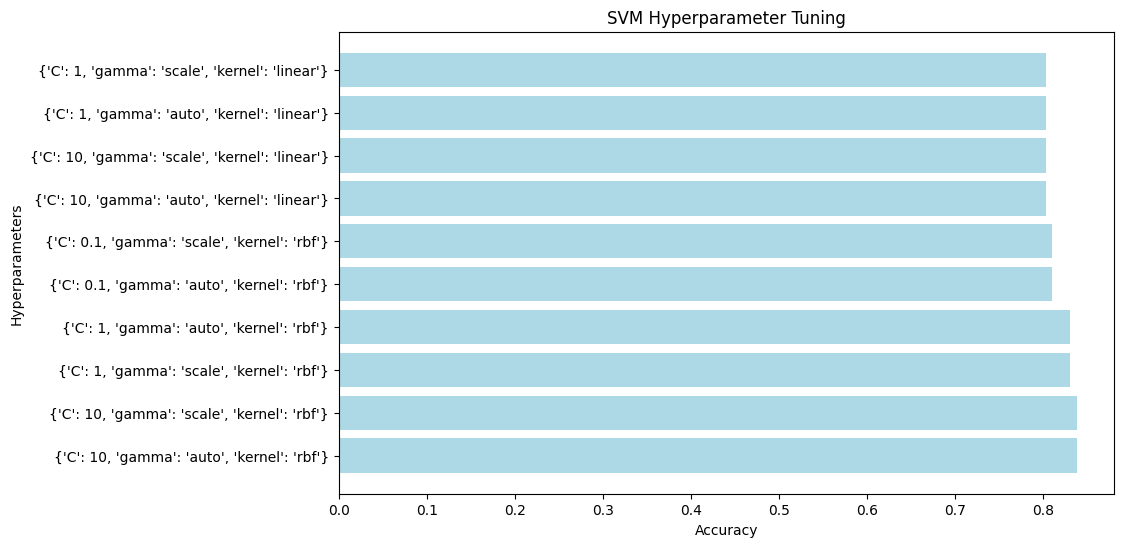

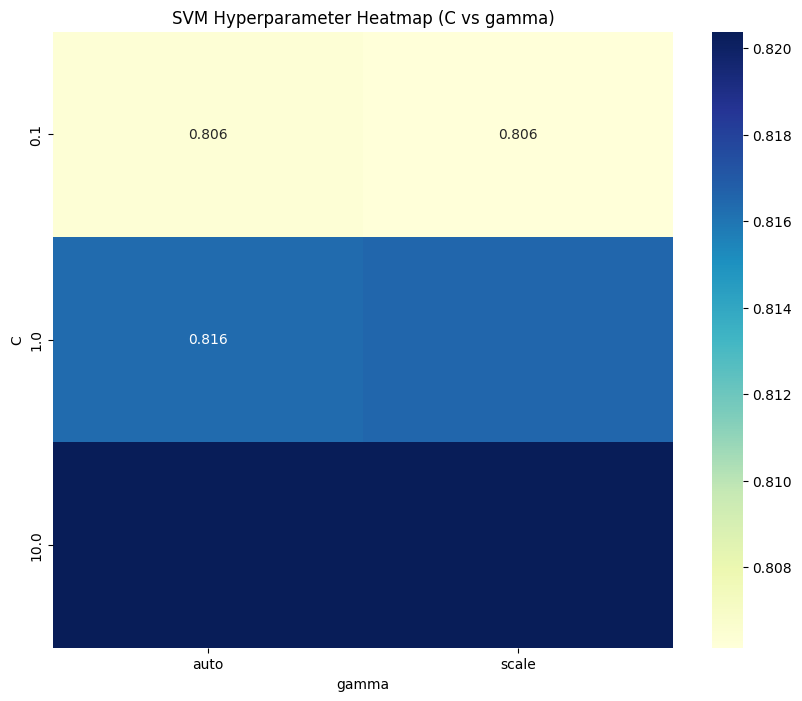

Best hyperparameters for SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


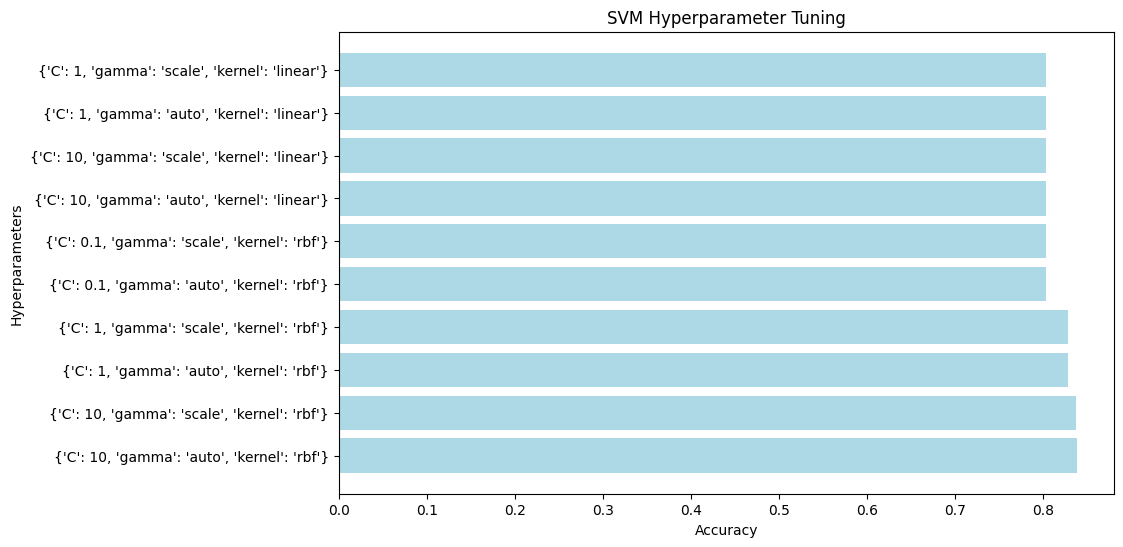

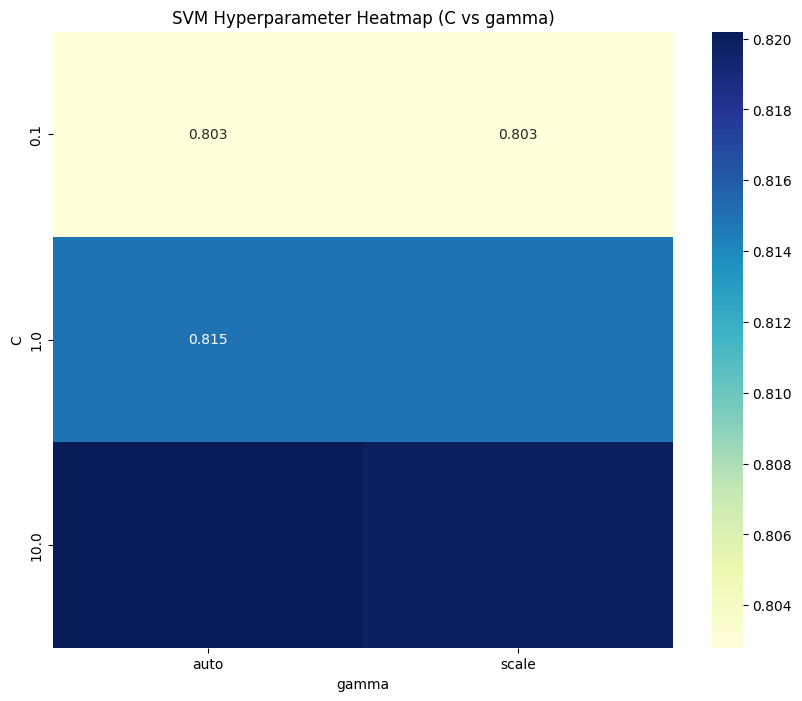

Best hyperparameters for SVM: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}


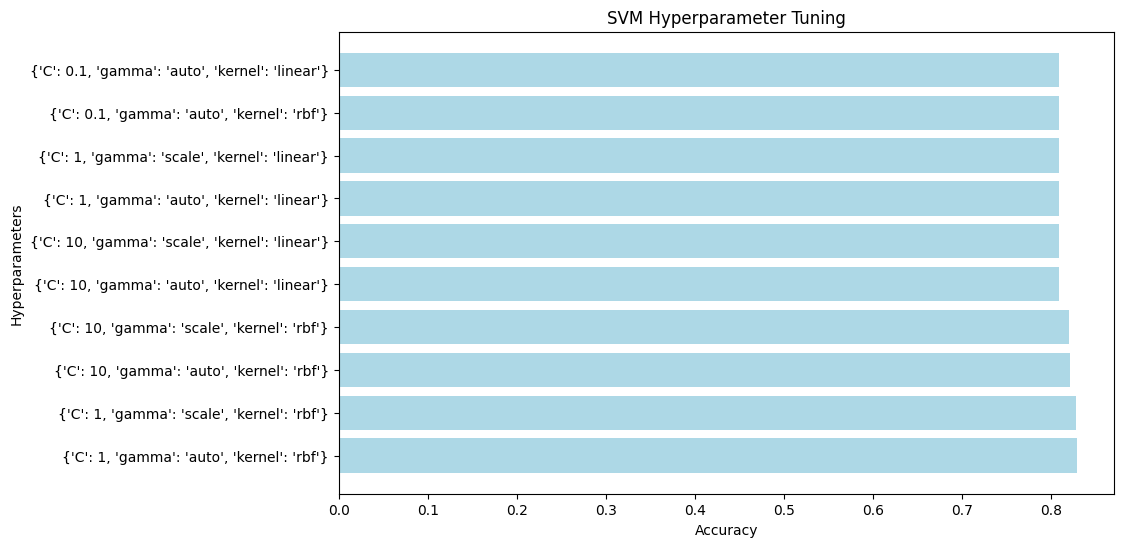

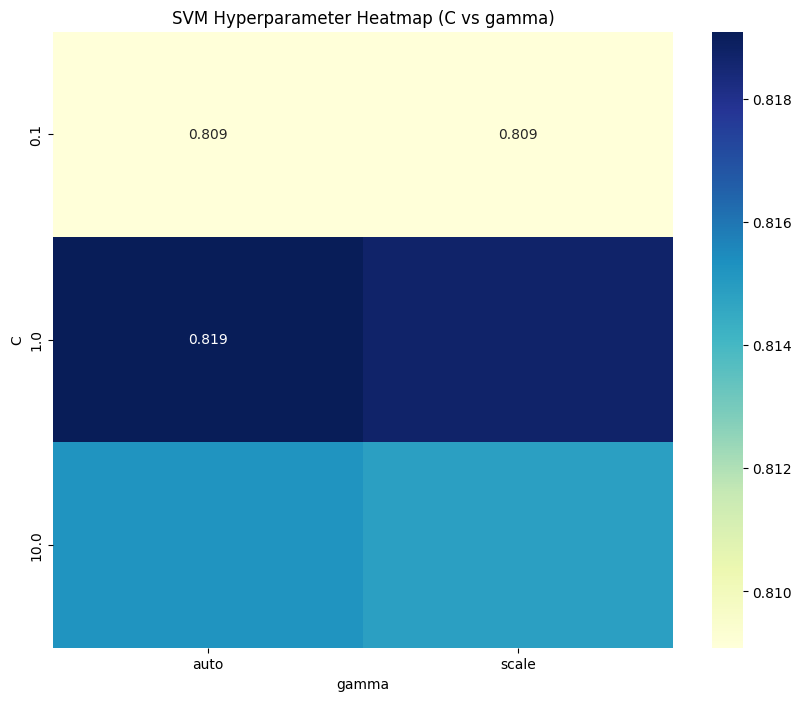

Best hyperparameters for SVM: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
--------------------------------------------------------------------
SVM 80% training split accuracy:  [0.88050799 0.83798345 0.84923077]
SVM 50% training split accuracy:  [0.8919335  0.83774422 0.84025854]
SVM 20% training split accuracy:  [0.84680523 0.82910603 0.82320123]


In [11]:
#all models for wine dataset
rf_80_wine, rf_80_wine_acc = rf_fit(X_wine, y_wine, 0.2)
rf_50_wine, rf_50_wine_acc = rf_fit(X_wine, y_wine, 0.5)
rf_20_wine, rf_20_wine_acc = rf_fit(X_wine, y_wine, 0.8)

print("Random Forest 80% training split accuracy: ", rf_80_wine_acc)
print("Random Forest 50% training split accuracy: ", rf_50_wine_acc)
print("Random Forest 20% training split accuracy: ", rf_20_wine_acc)

knn_80_wine, knn_80_wine_acc = knn_fit(X_wine, y_wine, 0.2)
knn_50_wine, knn_50_wine_acc = knn_fit(X_wine, y_wine, 0.5)
knn_20_wine, knn_20_wine_acc = knn_fit(X_wine, y_wine, 0.8)

print("--------------------------------------------------------------------")
print("KNN 80% training split accuracy: ", knn_80_wine_acc)
print("KNN 50% training split accuracy: ", knn_50_wine_acc)
print("KNN 20% training split accuracy: ", knn_20_wine_acc)

svm_80_wine, svm_80_wine_acc = svm_fit(X_wine, y_wine, 0.2)
svm_50_wine, svm_50_wine_acc = svm_fit(X_wine, y_wine, 0.5)
svm_20_wine, svm_20_wine_acc = svm_fit(X_wine, y_wine, 0.8)

print("--------------------------------------------------------------------")
print("SVM 80% training split accuracy: ", svm_80_wine_acc)
print("SVM 50% training split accuracy: ", svm_50_wine_acc)
print("SVM 20% training split accuracy: ", svm_20_wine_acc)